# 제주도 버스승차 인원 예측
- ## data 415423 rows × 21 columns
### train columns
- id : 해당 데이터에서의 고유한 id
- data : 날짜
- bus_route_id : 노선 ID
- in_out : 시내버스, 시외버스 구분
- station_code : 해당 승하차 정류소의 id
- station_name : 해당 승하차 정류소의 이름
- latitude : 해당 버스정류장의 위도
- longitude : 해당 버스정류장의 경도
- X-Y_ride : X:00:00 ~ x:59:59까지 승차한 인원 수
- X-Y_takeoff : X:00:00 ~ x:59:59까지 하차한 인원 수
- 18-20_ride : 18:00:00부터 19:59:59까지 승차한 인원 수

In [117]:
# 추가되는 패키지는 여기에서 import 해주세요
import missingno
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm

In [293]:
# 데이터 load
train = pd.read_csv('train.csv',date_parser='date')
train.tail()

id        date  bus_route_id in_out  station_code  station_name  \
415418  415418  2019-09-30      32820000     시내          1129  한림환승정류장(한림리)   
415419  415419  2019-09-30      32820000     시내          1564     제주시외버스터미널   
415420  415420  2019-09-30      32820000     시내          2322          해병부대   
415421  415421  2019-09-30      32820000     시내          3291  애월환승정류장(애월리)   
415422  415422  2019-09-30      32820000     시내       6115100    서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  9~10_ride  10~11_ride  \
415418  33.41437  126.26336       4.0       0.0  ...        0.0         0.0   
415419  33.49946  126.51479       4.0       0.0  ...        0.0         0.0   
415420  33.23100  126.26273       0.0       0.0  ...        0.0         0.0   
415421  33.46483  126.31870       1.0       0.0  ...        0.0         0.0   
415422  33.24873  126.50799       0.0       0.0  ...        0.0         0.0   

        11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  \
415418         0.0          0.0          0.0          0.0           0.0   
415419         0.0          0.0          0.0          0.0           0.0   
415420         0.0          0.0          1.0          0.0           0.0   
415421         0.0          0.0          0.0          0.0           0.0   
415422         0.0          0.0          0.0          4.0           0.0   

        10~11_takeoff  11~12_takeoff  18~20_ride  
415418            0.0            0.0         0.0  
415419            0.0            0.0         0.0  
415420            0.0            0.0         0.0  
415421            0.0            0.0         0.0  
415422            0.0            0.0         0.0  

[5 rows x 21 columns]

In [249]:
# Nan data 확인
# Nan data 없는것으로 확인
missingno.matrix(train)
plt.show()

In [5]:
# Nan값이 없는것을 알수 있다.
# 정확히 Nan값이 없는것을 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
id               415423 non-null int64
date             415423 non-null object
bus_route_id     415423 non-null int64
in_out           415423 non-null object
station_code     415423 non-null int64
station_name     415423 non-null object
latitude         415423 non-null float64
longitude        415423 non-null float64
6~7_ride         415423 non-null float64
7~8_ride         415423 non-null float64
8~9_ride         415423 non-null float64
9~10_ride        415423 non-null float64
10~11_ride       415423 non-null float64
11~12_ride       415423 non-null float64
6~7_takeoff      415423 non-null float64
7~8_takeoff      415423 non-null float64
8~9_takeoff      415423 non-null float64
9~10_takeoff     415423 non-null float64
10~11_takeoff    415423 non-null float64
11~12_takeoff    415423 non-null float64
18~20_ride       415423 non-null float64
dtypes: float64(15), int64(3), object

In [6]:
# 분석에 필요없는 컬럼 확인을 위해 컬럼 갯수 확인
for i in train.columns:
    print(f'{i}의 갯수는 ',len(train[i].unique()))

id의 갯수는  415423
date의 갯수는  30
bus_route_id의 갯수는  613
in_out의 갯수는  2
station_code의 갯수는  3563
station_name의 갯수는  1961
latitude의 갯수는  3278
longitude의 갯수는  3446
6~7_ride의 갯수는  47
7~8_ride의 갯수는  80
8~9_ride의 갯수는  78
9~10_ride의 갯수는  66
10~11_ride의 갯수는  66
11~12_ride의 갯수는  69
6~7_takeoff의 갯수는  35
7~8_takeoff의 갯수는  51
8~9_takeoff의 갯수는  53
9~10_takeoff의 갯수는  46
10~11_takeoff의 갯수는  47
11~12_takeoff의 갯수는  55
18~20_ride의 갯수는  170


#### train column 의사결정
- id의 갯수는  415423개로 카테고리 변수이며 해당 변수를 분석에 사용할수 없어서 '삭제'
- date의 갯수는  30개로 카테고리 변수로 해당 변수를 분석에 사용 하기로 함 '킵'
    - 연도와 월은 2019년 9월만 있어서 의미가 없으나, 일과 요일은 사용할수 있을듯, 9월은 12,13,14가 추석임
    - 제주도는 관광도시로 추석에 인원이 더 많을수도 있음
- bus_route_id의 갯수는  613개로 카테고리 변수이며 해당 변수를 분석에 사용 할수는 없으나, 다른 분석에 쓰일수 있어서 '킵'
    - station_code별 bus_route_id의 갯수를 구하면 해당 정류장에 오는 버스노선의 수를 알수 있음.
- in_out의 갯수는  2개로 카테고리 변수이며, 해당 변수를 분석에 사용하기로 함 '킵'
    - 시내, 시외 비율 확인
- station_code의 갯수는  3563개로 카테고리 변수이며 분석에는 사용하지 않음
    - 정류소 구분을 위해 일단 킵
- station_name의 갯수는  1961개로 카테고리 변수이며 분석에는 사용하지 않음
    - 정류소 구분을 위해 일단 킵
- latitude의 갯수는  3278개로 위치정보이므로 일단 사용
    - 특정 지점을 기준하여 거리화 해보기
- longitude의 갯수는  3446개로 위치정보이므로 일단 사용
    - 특정 지점을 기준하여 거리화 해보기
- 6~7_ride의 갯수는  47 : 킵
    - 이하 말이 필요없음 무조건 킵
- 7~8_ride의 갯수는  80 : 킵
- 8~9_ride의 갯수는  78 : 킵
- 9~10_ride의 갯수는  66 : 킵
- 10~11_ride의 갯수는  66 : 킵
- 11~12_ride의 갯수는  69 : 킵
- 6~7_takeoff의 갯수는  35 : 킵
- 7~8_takeoff의 갯수는  51 : 킵
- 8~9_takeoff의 갯수는  53 : 킵
- 9~10_takeoff의 갯수는  46 : 킵
- 10~11_takeoff의 갯수는  47 : 킵
- 11~12_takeoff의 갯수는  55 : 킵
- 18~20_ride의 갯수는  170 : 킵

In [294]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')

In [295]:
# 분석에 완전히 필요없는 컬럼 id만 삭제
train.drop(['id'],axis=1,inplace=True)
train

date  bus_route_id in_out  station_code  station_name  latitude  \
0       2019-09-01       4270000     시외           344         제주썬호텔  33.48990   
1       2019-09-01       4270000     시외           357          한라병원  33.48944   
2       2019-09-01       4270000     시외           432          정존마을  33.48181   
3       2019-09-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
4       2019-09-01       4270000     시내          1646      중문관광단지입구  33.25579   
...            ...           ...    ...           ...           ...       ...   
415418  2019-09-30      32820000     시내          1129  한림환승정류장(한림리)  33.41437   
415419  2019-09-30      32820000     시내          1564     제주시외버스터미널  33.49946   
415420  2019-09-30      32820000     시내          2322          해병부대  33.23100   
415421  2019-09-30      32820000     시내          3291  애월환승정류장(애월리)  33.46483   
415422  2019-09-30      32820000     시내       6115100    서귀포시외버스터미널  33.24873   

        longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  \
0       126.49373       0.0       1.0       2.0        5.0         2.0   
1       126.48508       1.0       4.0       4.0        2.0         5.0   
2       126.47352       1.0       1.0       0.0        2.0         0.0   
3       126.49252       0.0      17.0       6.0       26.0        14.0   
4       126.41260       0.0       0.0       0.0        0.0         0.0   
...           ...       ...       ...       ...        ...         ...   
415418  126.26336       4.0       0.0       0.0        0.0         0.0   
415419  126.51479       4.0       0.0       0.0        0.0         0.0   
415420  126.26273       0.0       0.0       0.0        0.0         0.0   
415421  126.31870       1.0       0.0       0.0        0.0         0.0   
415422  126.50799       0.0       0.0       0.0        0.0         0.0   

        11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  \
0              6.0          0.0          0.0          0.0           0.0   
1              6.0          0.0          0.0          0.0           0.0   
2              0.0          0.0          0.0          0.0           0.0   
3             16.0          0.0          0.0          0.0           0.0   
4              0.0          0.0          0.0          0.0           1.0   
...            ...          ...          ...          ...           ...   
415418         0.0          0.0          0.0          0.0           0.0   
415419         0.0          0.0          0.0          0.0           0.0   
415420         0.0          0.0          1.0          0.0           0.0   
415421         0.0          0.0          0.0          0.0           0.0   
415422         0.0          0.0          0.0          4.0           0.0   

        10~11_takeoff  11~12_takeoff  18~20_ride  
0                 0.0            0.0         0.0  
1                 0.0            0.0         5.0  
2                 0.0            0.0         2.0  
3                 0.0            0.0        53.0  
4                 0.0            0.0         0.0  
...               ...            ...         ...  
415418            0.0            0.0         0.0  
415419            0.0            0.0         0.0  
415420            0.0            0.0         0.0  
415421            0.0            0.0         0.0  
415422            0.0            0.0         0.0  

[415423 rows x 20 columns]

In [296]:
# 분석을 위해 컬럼명 수정
train.rename(columns={'6~7_ride': 'ride6', '7~8_ride': 'ride7', '8~9_ride': 'ride8',\
                      '9~10_ride': 'ride9', '10~11_ride': 'ride10', '11~12_ride': 'ride11', 
                      '6~7_takeoff': 'off6', '7~8_takeoff': 'off7', '8~9_takeoff': 'off8', \
                      '9~10_takeoff': 'off9', '10~11_takeoff': 'off10', '11~12_takeoff': 'off11',\
                      '18~20_ride': 'ride18'},inplace=True)
train

date  bus_route_id in_out  station_code  station_name  latitude  \
0       2019-09-01       4270000     시외           344         제주썬호텔  33.48990   
1       2019-09-01       4270000     시외           357          한라병원  33.48944   
2       2019-09-01       4270000     시외           432          정존마을  33.48181   
3       2019-09-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
4       2019-09-01       4270000     시내          1646      중문관광단지입구  33.25579   
...            ...           ...    ...           ...           ...       ...   
415418  2019-09-30      32820000     시내          1129  한림환승정류장(한림리)  33.41437   
415419  2019-09-30      32820000     시내          1564     제주시외버스터미널  33.49946   
415420  2019-09-30      32820000     시내          2322          해병부대  33.23100   
415421  2019-09-30      32820000     시내          3291  애월환승정류장(애월리)  33.46483   
415422  2019-09-30      32820000     시내       6115100    서귀포시외버스터미널  33.24873   

        longitude  ride6  ride7  ride8  ride9  ride10  ride11  off6  off7  \
0       126.49373    0.0    1.0    2.0    5.0     2.0     6.0   0.0   0.0   
1       126.48508    1.0    4.0    4.0    2.0     5.0     6.0   0.0   0.0   
2       126.47352    1.0    1.0    0.0    2.0     0.0     0.0   0.0   0.0   
3       126.49252    0.0   17.0    6.0   26.0    14.0    16.0   0.0   0.0   
4       126.41260    0.0    0.0    0.0    0.0     0.0     0.0   0.0   0.0   
...           ...    ...    ...    ...    ...     ...     ...   ...   ...   
415418  126.26336    4.0    0.0    0.0    0.0     0.0     0.0   0.0   0.0   
415419  126.51479    4.0    0.0    0.0    0.0     0.0     0.0   0.0   0.0   
415420  126.26273    0.0    0.0    0.0    0.0     0.0     0.0   0.0   1.0   
415421  126.31870    1.0    0.0    0.0    0.0     0.0     0.0   0.0   0.0   
415422  126.50799    0.0    0.0    0.0    0.0     0.0     0.0   0.0   0.0   

        off8  off9  off10  off11  ride18  
0        0.0   0.0    0.0    0.0     0.0  
1        0.0   0.0    0.0    0.0     5.0  
2        0.0   0.0    0.0    0.0     2.0  
3        0.0   0.0    0.0    0.0    53.0  
4        0.0   1.0    0.0    0.0     0.0  
...      ...   ...    ...    ...     ...  
415418   0.0   0.0    0.0    0.0     0.0  
415419   0.0   0.0    0.0    0.0     0.0  
415420   0.0   0.0    0.0    0.0     0.0  
415421   0.0   0.0    0.0    0.0     0.0  
415422   4.0   0.0    0.0    0.0     0.0  

[415423 rows x 20 columns]

In [297]:
# 시작 날짜와, 끝 날짜 확인
print(train['date'].min())
print(train['date'].max())

2019-09-01
2019-09-30


In [298]:
# date 타입 변경
train['date'] = train['date'].astype('datetime64')
# 9월 1일 ~ 9월 30일 데이터이니까, day만 따로 가져옴
train['date_day'] = train['date'].dt.day
# 월(0) ~ 일(6) 데이터로 변환
train['date_dayofweek'] = train['date'].dt.dayofweek
train['date_dayofname']= train['date'].dt.weekday_name
train[['date','date_dayofweek','date_day','date_dayofname']]

date  date_dayofweek  date_day date_dayofname
0      2019-09-01               6         1         Sunday
1      2019-09-01               6         1         Sunday
2      2019-09-01               6         1         Sunday
3      2019-09-01               6         1         Sunday
4      2019-09-01               6         1         Sunday
...           ...             ...       ...            ...
415418 2019-09-30               0        30         Monday
415419 2019-09-30               0        30         Monday
415420 2019-09-30               0        30         Monday
415421 2019-09-30               0        30         Monday
415422 2019-09-30               0        30         Monday

[415423 rows x 4 columns]

In [329]:
# 추석 추가 컬럼명 : 'Thanksgiving_Day'
train['Thanksgiving_Day'] = 0
train.loc[train['date'] == '2019-09-14', 'Thanksgiving_Day'] = 1
train.loc[train['date'] == '2019-09-13', 'Thanksgiving_Day'] = 1
train.loc[train['date'] == '2019-09-12', 'Thanksgiving_Day'] = 1
print(train['Thanksgiving_Day'].sum())
# 제대로 바뀌었는지 확인
train[train['date'] == '2019-09-14'].count()[0] + \
train[train['date'] == '2019-09-12'].count()[0] + \
train[train['date'] == '2019-09-13'].count()[0]

30719


30719

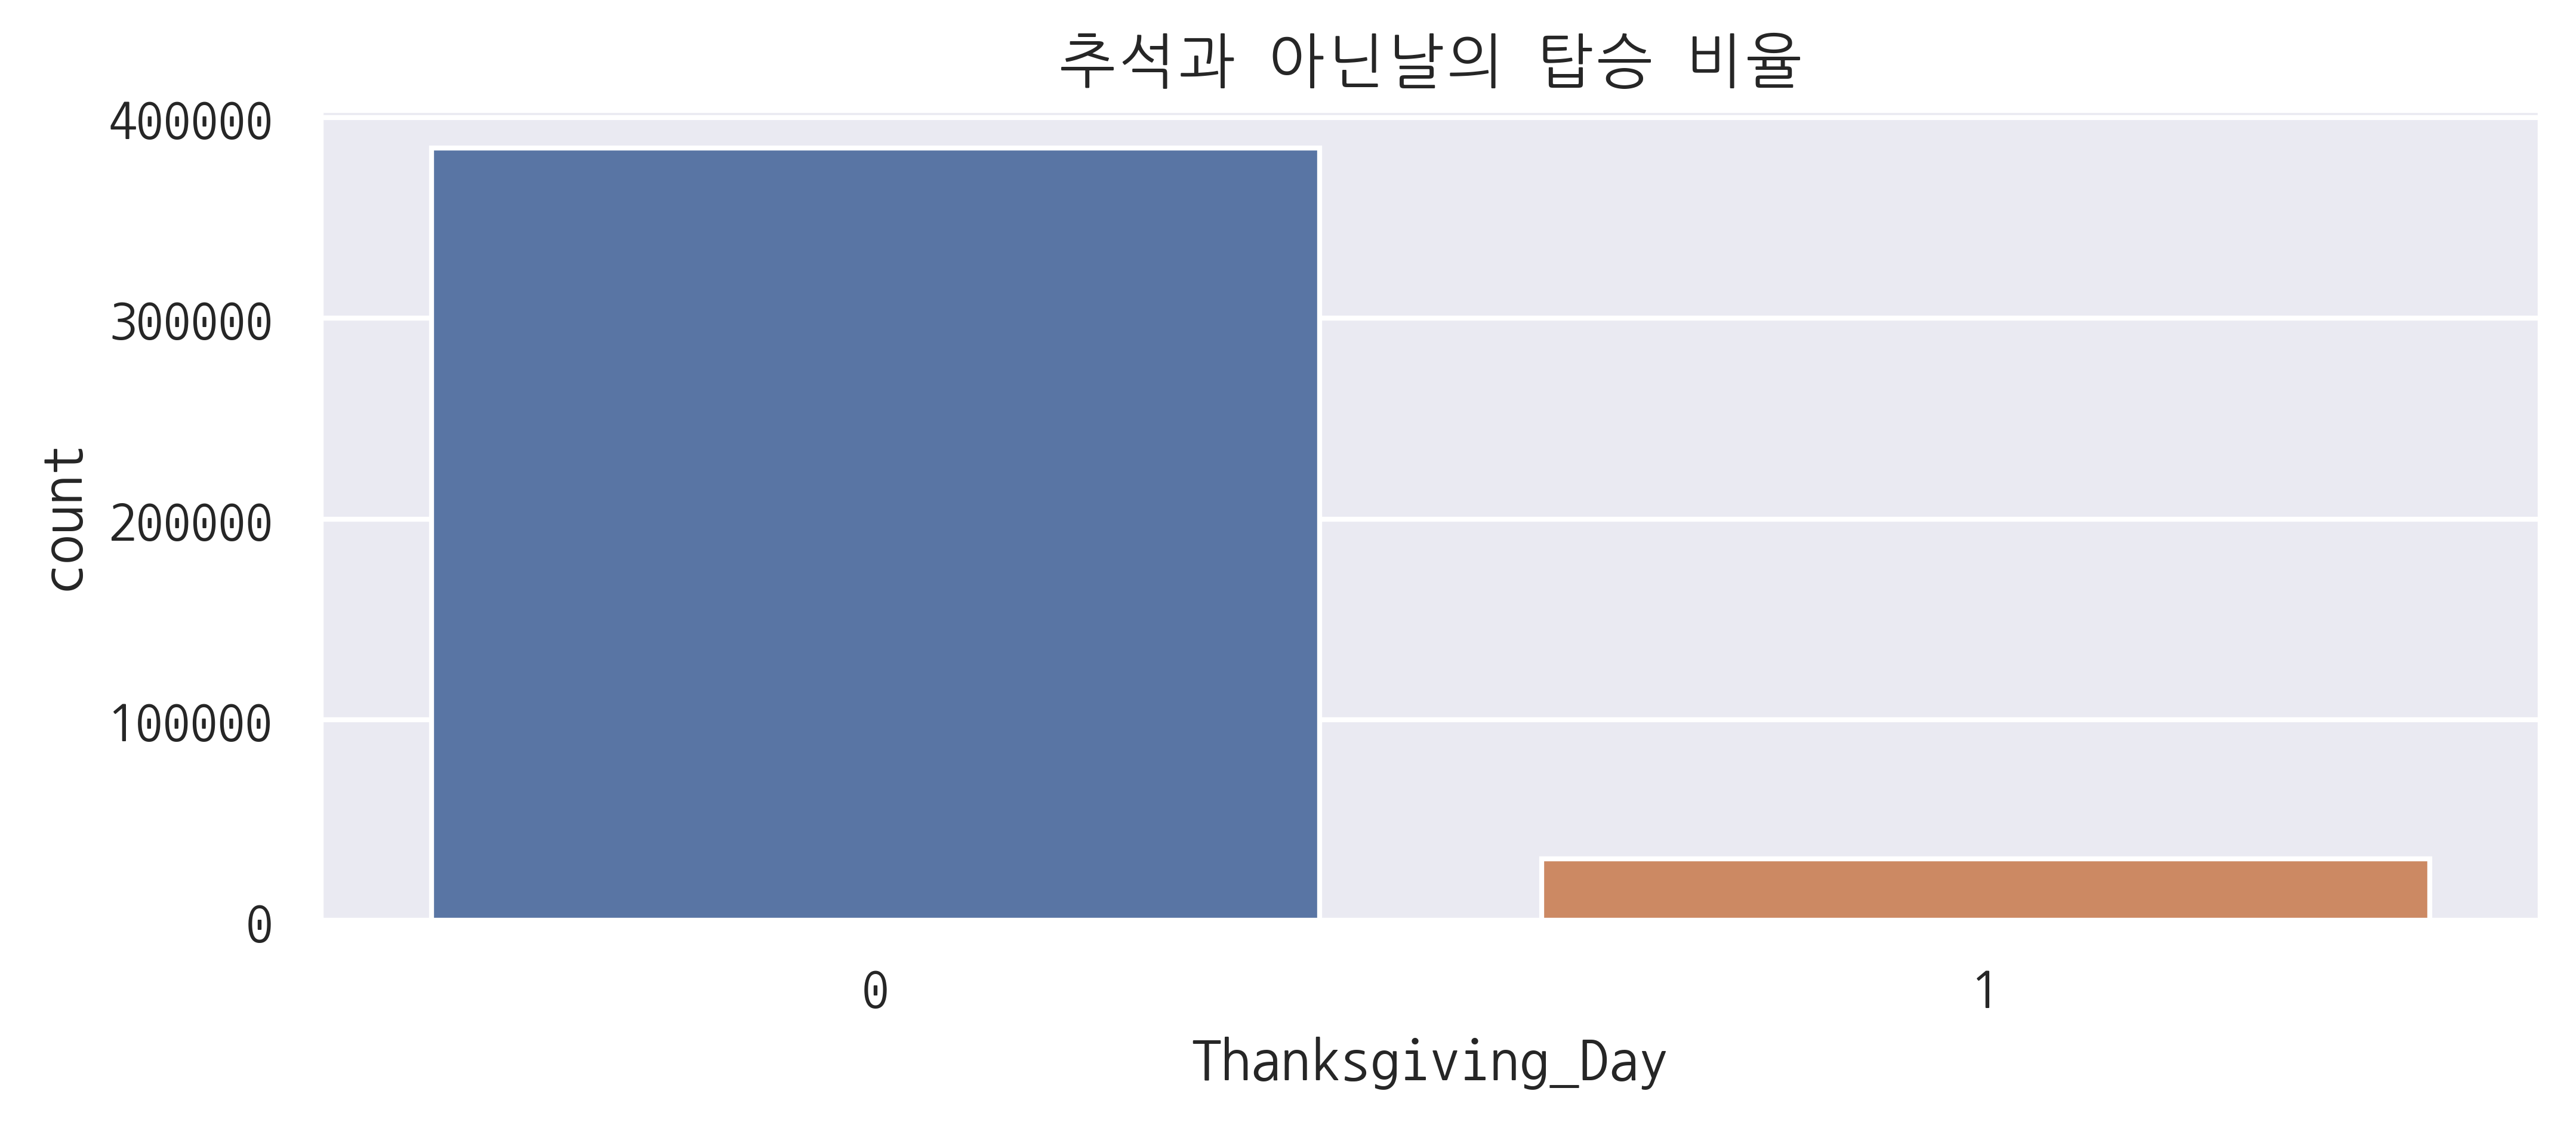

In [338]:
sns.countplot(data=train, x= 'Thanksgiving_Day')
plt.title('추석과 아닌날의 탑승 비율')
plt.show()

In [344]:
# 추석 3일동안 버스 이용률이 전체의 7.4%임
train['Thanksgiving_Day'].value_counts() / train['Thanksgiving_Day'].value_counts().sum() * 100

0    92.605369
1     7.394631
Name: Thanksgiving_Day, dtype: float64

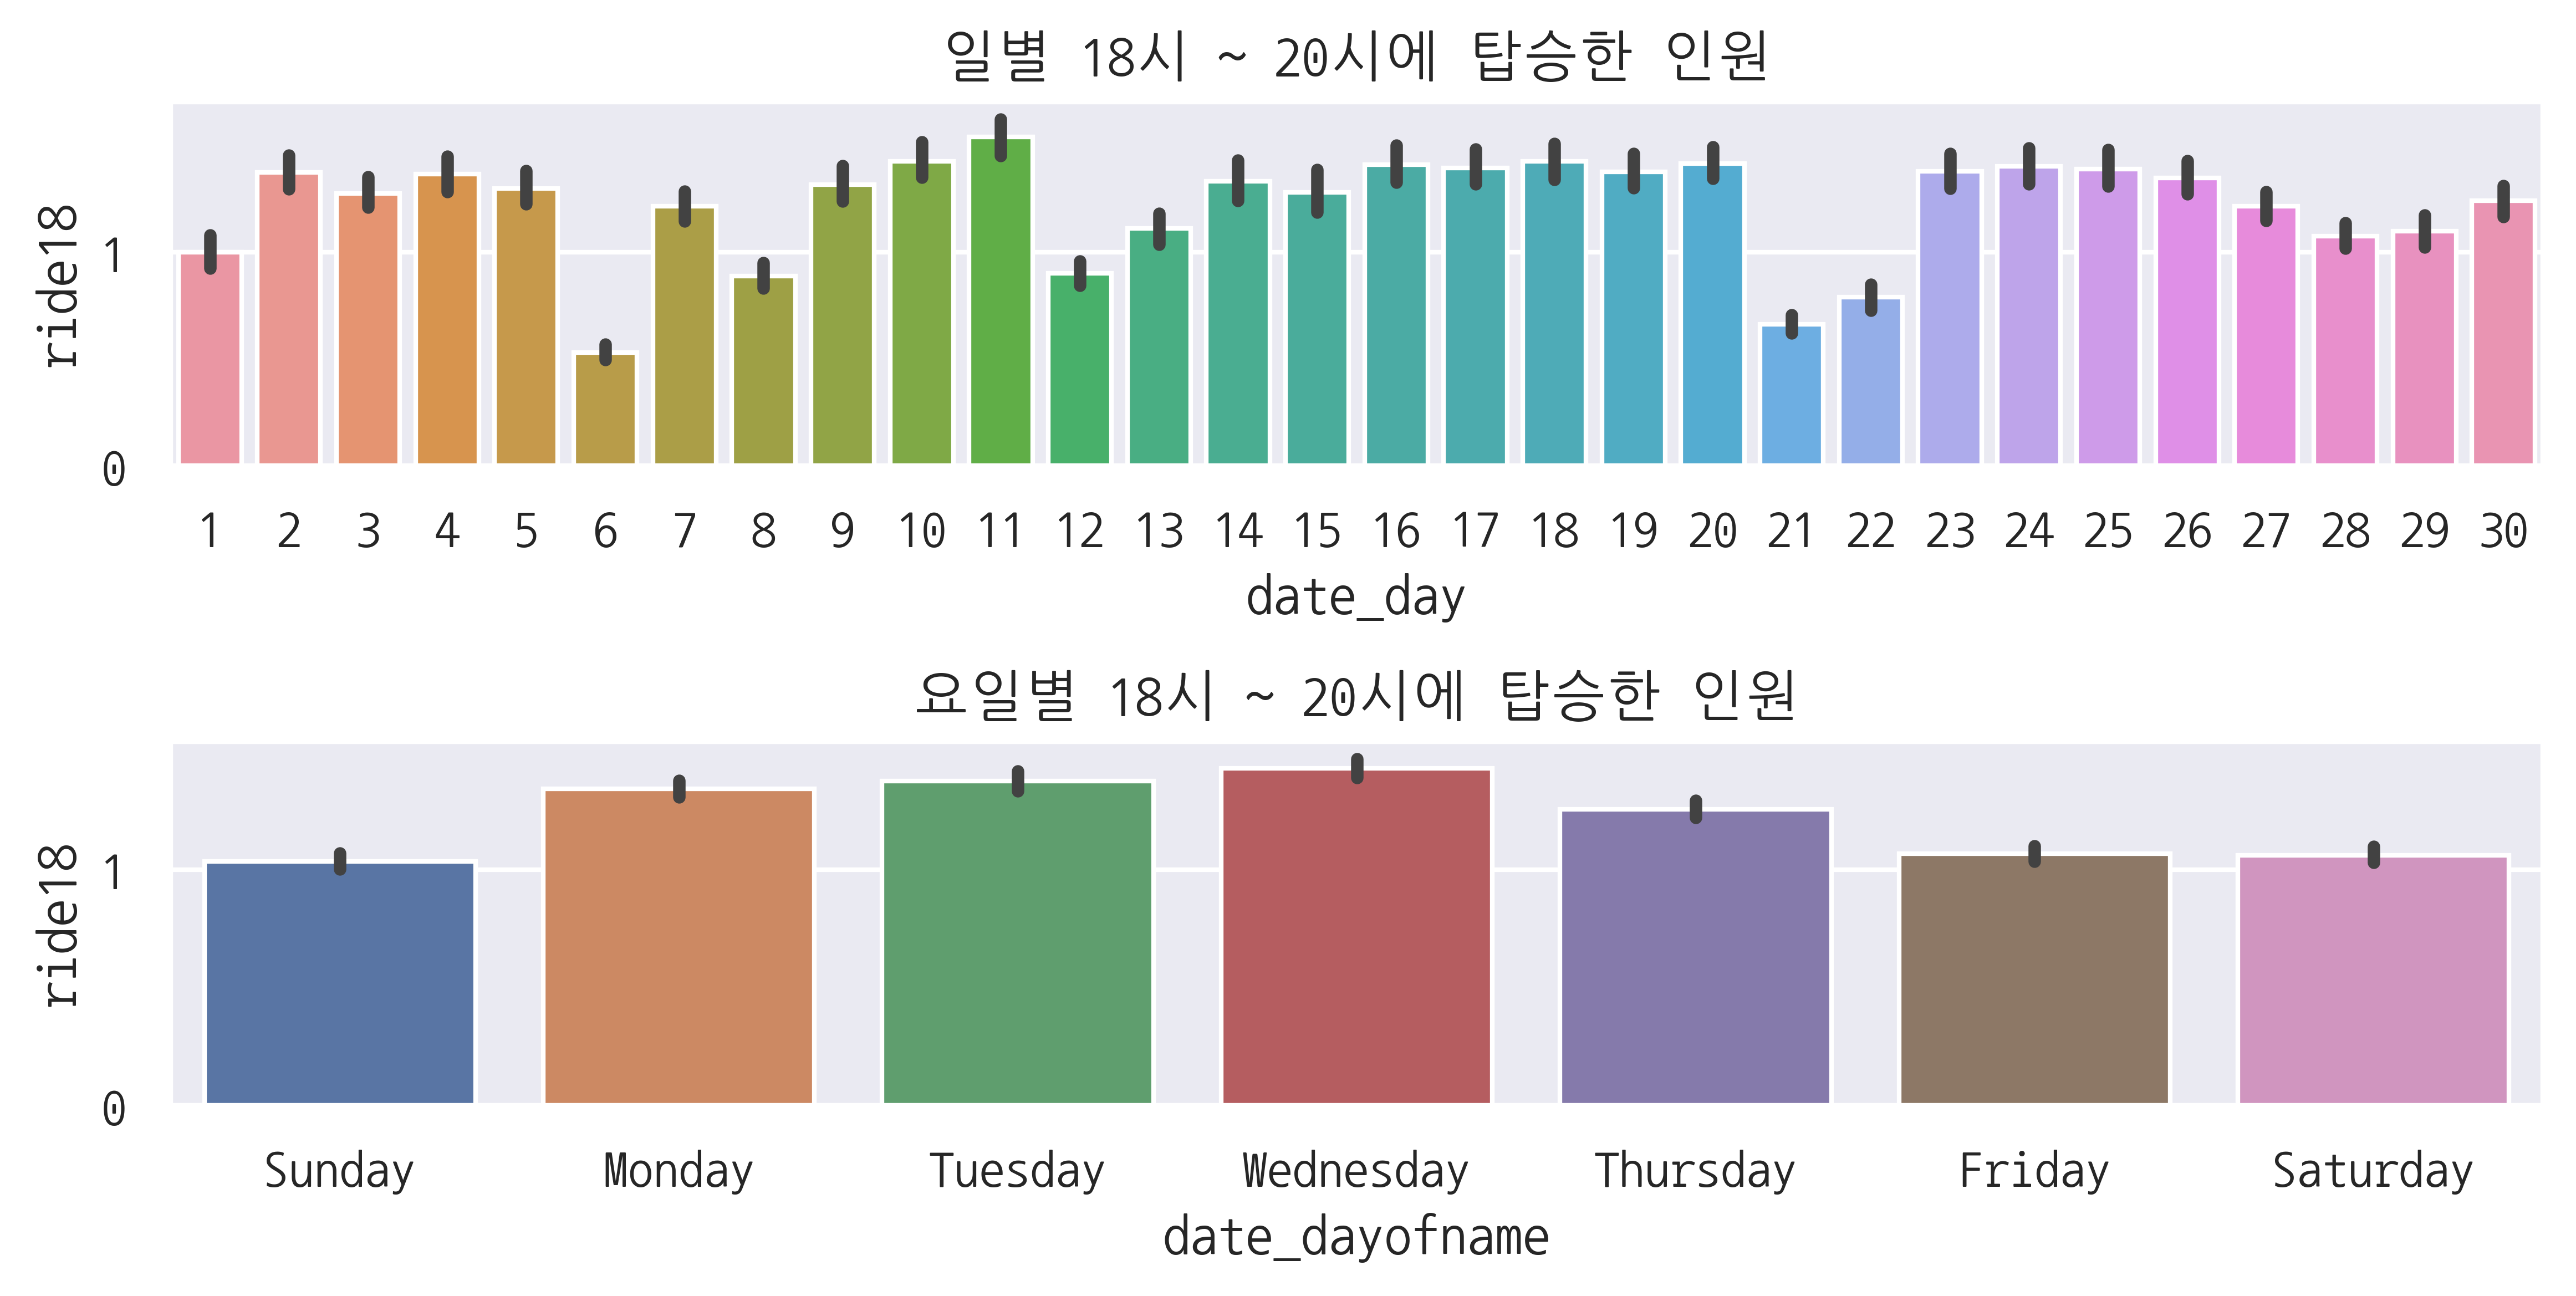

In [343]:
# 일별, 요일별 탑승한 인원 그래프
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.title('일별 18시 ~ 20시에 탑승한 인원')
sns.barplot(x='date_day', y='ride18', data=train)

plt.subplot(212)
plt.title('요일별 18시 ~ 20시에 탑승한 인원')
sns.barplot(x='date_dayofname', y='ride18', data=train)
plt.tight_layout()
plt.show()

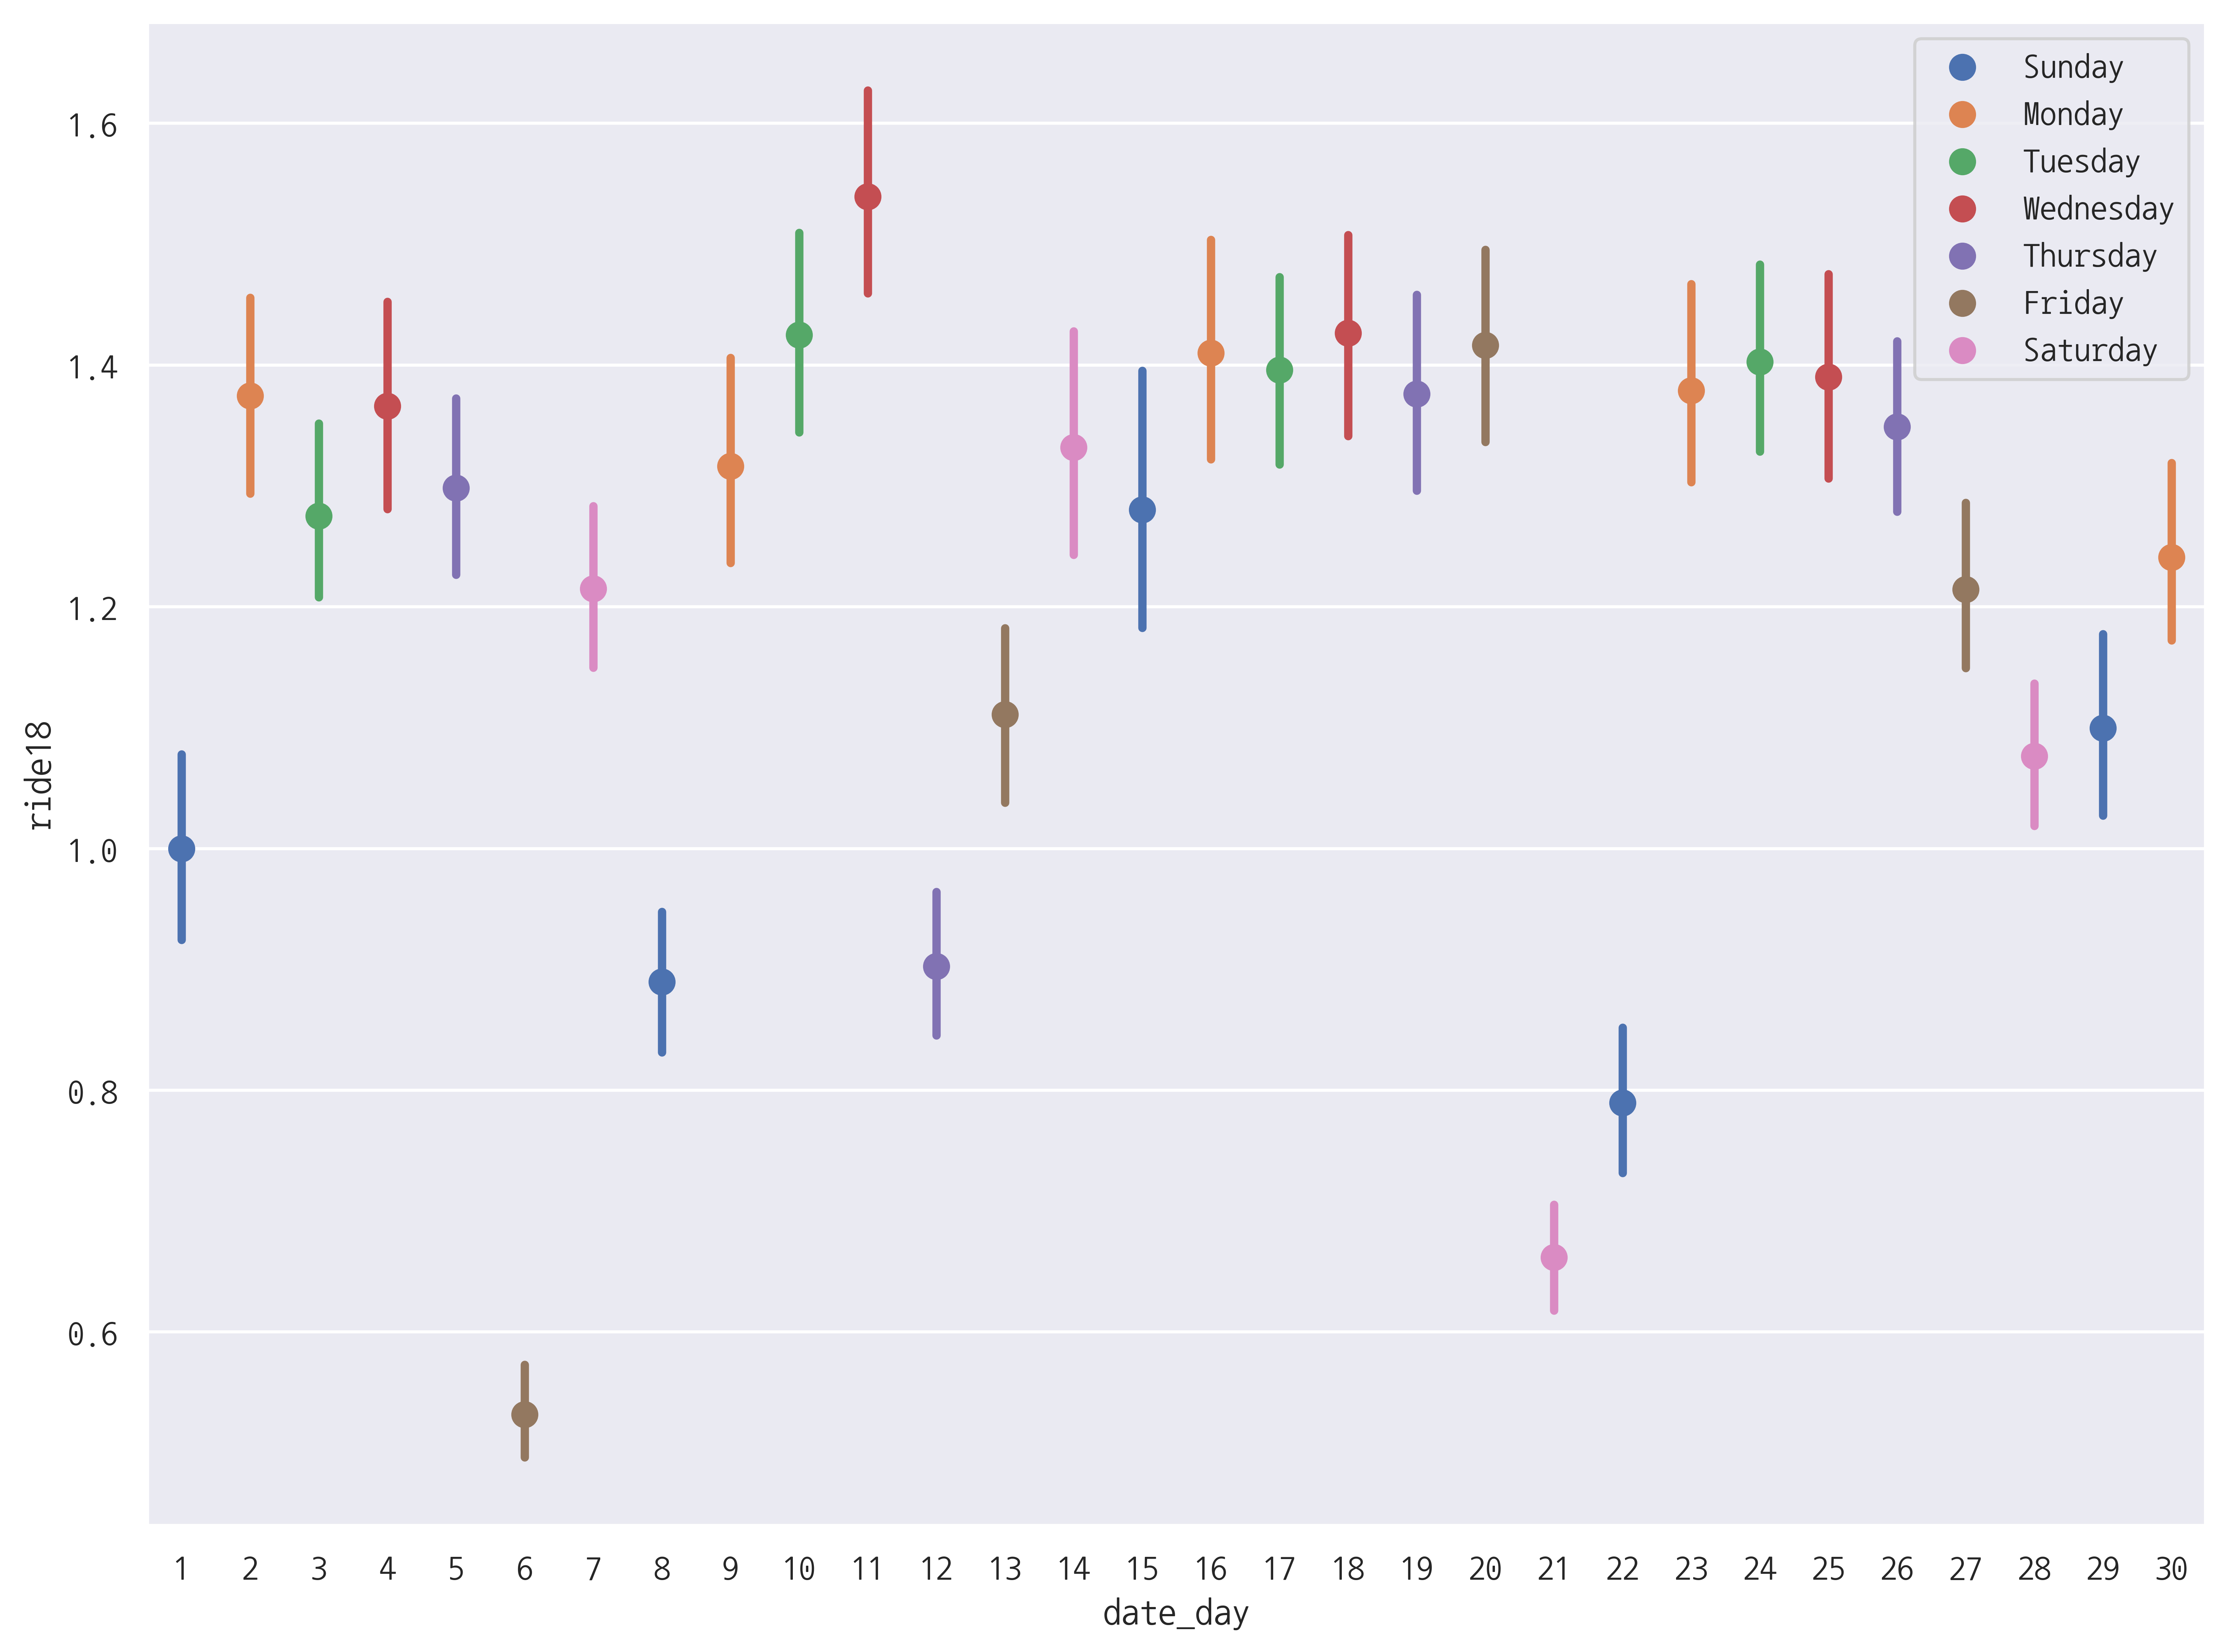

In [340]:
# 아래 그래프는 pointplot인데, 이상하게 나옴. 필요없으면 삭제하셔도 무방
plt.figure(figsize=(12,9))
sns.pointplot(data=train, x='date_day', y='ride18',hue='date_dayofname',linestyles='-') 
plt.legend()
plt.show()

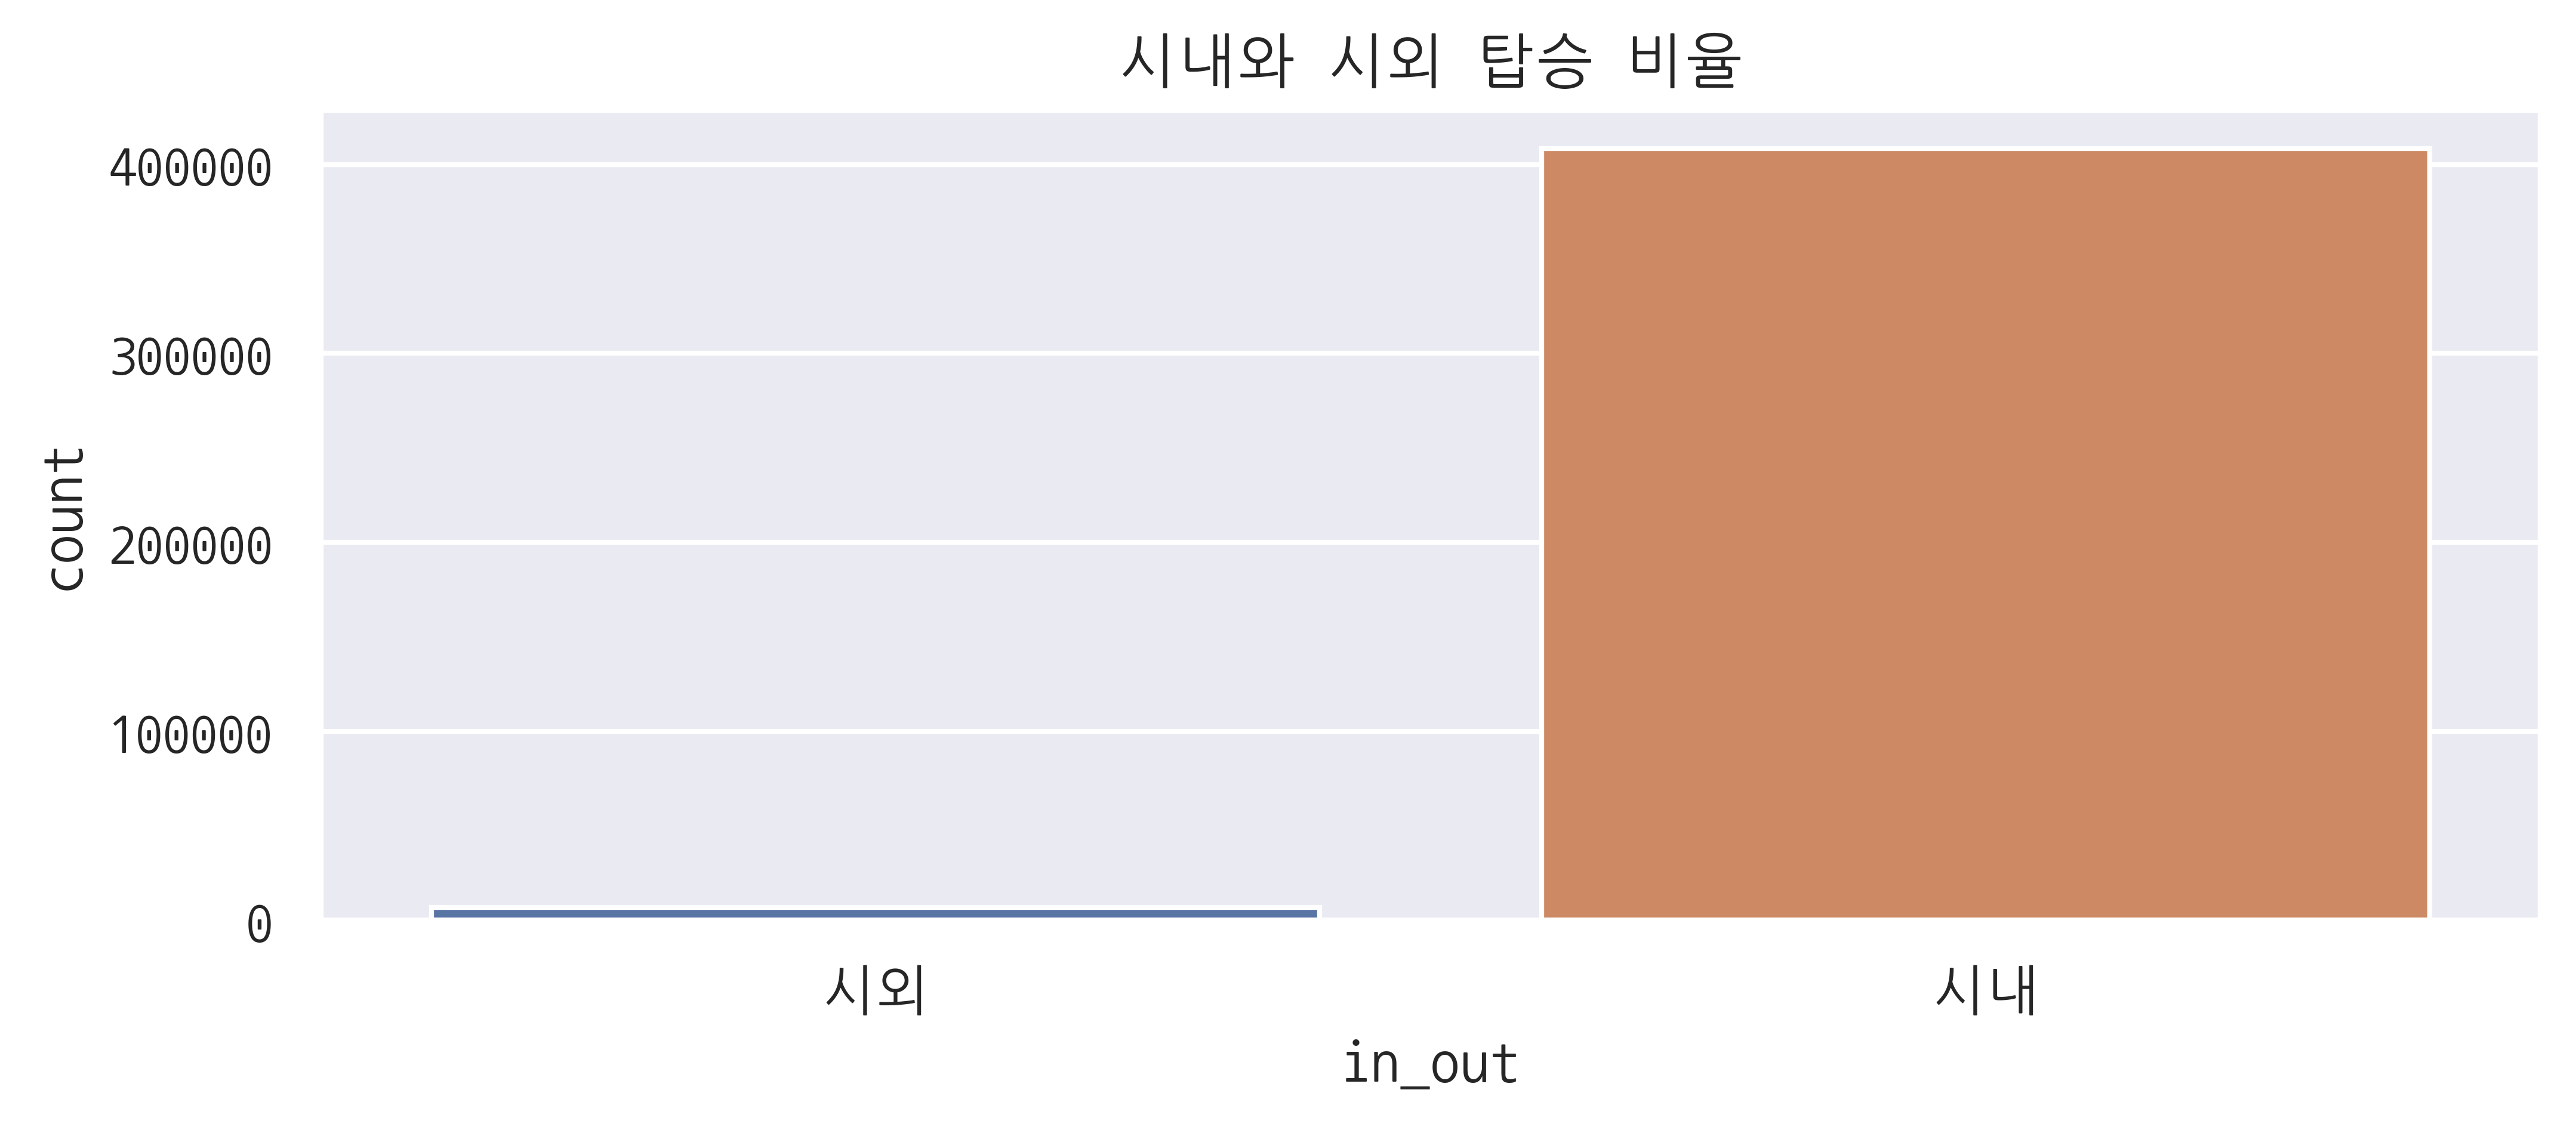

In [341]:
# 시내와 시외 탑승비율
# 제주도의 시는 제주시와 서귀포시를 의미.
# 시외버스는 거의 없다는것을 알수있고, 제주도의 시외버스터미널은 제주시와 서귀포시에 각 한개씩 있음.
# 이자료를 비추어보아, 위도경도를 거리화 할때 제주시와 서귀포시를 나누는것은 의미있을수도 있음.
sns.countplot(data=train, x= 'in_out')
plt.title('시내와 시외 탑승 비율')
plt.show()

In [342]:
# 시내와 시외버스 비율 약 98.3과 1.7
train['in_out'].value_counts() / train['in_out'].value_counts().sum() * 100

시내    98.333506
시외     1.666494
Name: in_out, dtype: float64

### 승하차 인원 분석

In [348]:
# 승하차 인원 피봇테이블 생성
values = ['ride6', 'ride7', 'ride8',
          'ride9', 'ride10', 'ride11', 'off6', 'off7', 'off8', 'off9', 'off10',
          'off11', 'ride18']
values_ride = ['ride6', 'ride7', 'ride8',
               'ride9', 'ride10', 'ride11']
values_off = ['off6', 'off7', 'off8', 'off9', 'off10',
              'off11']

table_all = pd.pivot_table(train, index='station_name', aggfunc=sum, values=values)
table_ride = pd.pivot_table(train, index='station_name', aggfunc=sum, values=values_ride)
table_off = pd.pivot_table(train, index='station_name', aggfunc=sum, values=values_off)
table_ride18 = pd.pivot_table(train, index='station_name', aggfunc=sum, values='ride18')

In [349]:
# 전체 승하차 인원 분석
table_all['all'] = table_all['off10'] + table_all['off11'] + table_all['off6'] + table_all['off7'] + \
    table_all['off8']+table_all['off9'] + table_all['ride18'] + table_all['ride6'] + table_all['ride7'] + \
    table_all['ride8']+table_all['ride9'] + table_all['ride10'] + table_all['ride11']
table_all['percent'] = table_all['all'] / table_all['all'].sum() * 100
table_all

off10  off11  off6   off7   off8   off9  ride10  ride11  ride18  \
station_name                                                                    
(구)구판장          5.0    9.0   0.0    0.0    1.0    0.0    11.0     0.0     0.0   
(구)중문동주민센터    139.0   70.0  12.0   79.0  138.0  131.0   128.0   121.0   215.0   
(구)중앙파출소      288.0  322.0  71.0  183.0  412.0  316.0   311.0   225.0   454.0   
(구)화산초등학교       6.0    1.0   0.0    0.0    0.0    0.0     0.0     0.0     0.0   
1100고지휴게소      16.0   12.0   0.0    0.0   20.0    7.0    10.0    24.0     1.0   
...             ...    ...   ...    ...    ...    ...     ...     ...     ...   
흙통             42.0   37.0   7.0   11.0   11.0   43.0    37.0    32.0    12.0   
흥국사             3.0    2.0   0.0    0.0   19.0    2.0     1.0     1.0     0.0   
흥덕사             5.0    3.0   0.0    0.0    1.0    2.0     1.0     6.0     0.0   
희진주유소          14.0   13.0   1.0    6.0   22.0   14.0    29.0    21.0    23.0   
히귀반석            4.0    2.0   0.0    1.0   13.0    2.0    15.0     3.0     2.0   

              ride6  ride7  ride8  ride9     all   percent  
station_name                                                
(구)구판장          0.0   10.0   34.0    6.0    76.0  0.002530  
(구)중문동주민센터     93.0  245.0  315.0  207.0  1893.0  0.063022  
(구)중앙파출소      110.0  126.0  136.0  258.0  3212.0  0.106934  
(구)화산초등학교       0.0   26.0    3.0    1.0    37.0  0.001232  
1100고지휴게소       0.0    2.0    4.0    4.0   100.0  0.003329  
...             ...    ...    ...    ...     ...       ...  
흙통             11.0   54.0   40.0   30.0   367.0  0.012218  
흥국사             1.0    1.0    3.0    3.0    36.0  0.001199  
흥덕사             0.0    1.0    2.0    5.0    26.0  0.000866  
희진주유소          15.0   87.0   81.0   45.0   371.0  0.012351  
히귀반석           21.0   26.0   40.0    4.0   133.0  0.004428  

[1961 rows x 15 columns]

In [350]:
# 전체 승하차 인원이 가장 높은 10군데 정류장
# 하위는 ascending옵션을 지우시면 됨
table_all_top_10= table_all.sort_values(by='all',ascending = False)[:10]
table_all_top_10

off10   off11    off6    off7    off8    off9  ride10  ride11  \
station_name                                                                    
한라병원           3879.0  3182.0  1429.0  4026.0  6164.0  5063.0  5779.0  5464.0   
제주버스터미널        3617.0  4054.0  2063.0  3005.0  3665.0  3912.0  4147.0  3751.0   
제주시청(광양방면)     2677.0  2834.0   580.0  1519.0  2839.0  2537.0  3569.0  4019.0   
제주대학교          2360.0  1501.0   373.0  1584.0  3707.0  2184.0  2369.0  3342.0   
제주시청(아라방면)     2866.0  3054.0   993.0  2186.0  3319.0  3115.0  2955.0  2818.0   
제주도청신제주로터리     2128.0  2310.0   717.0  2249.0  4084.0  2517.0  3281.0  2859.0   
동문로터리(동문시장)    2866.0  2301.0   578.0   935.0  1672.0  2373.0  3465.0  4008.0   
노형오거리          1722.0  1460.0   410.0  1045.0  1868.0  1815.0  3209.0  3423.0   
제주시외버스터미널        63.0    66.0    26.0    67.0   150.0    78.0  3847.0  3111.0   
제주국제공항(구제주방면)  1541.0  1597.0  1375.0  2311.0  2463.0  1692.0  1379.0  1512.0   

                ride18   ride6   ride7   ride8   ride9      all   percent  
station_name                                                               
한라병원           13944.0  2642.0  6095.0  6864.0  5927.0  70458.0  2.345681  
제주버스터미널         9451.0   849.0  3258.0  3708.0  4572.0  50052.0  1.666327  
제주시청(광양방면)     14206.0  1515.0  2526.0  3583.0  3284.0  45688.0  1.521041  
제주대학교          20103.0   673.0  2102.0  3076.0  1964.0  45338.0  1.509388  
제주시청(아라방면)     10375.0  1842.0  3924.0  4461.0  3162.0  45070.0  1.500466  
제주도청신제주로터리      9398.0  1698.0  4020.0  4661.0  3640.0  43562.0  1.450262  
동문로터리(동문시장)     9567.0   734.0  1610.0  1635.0  2157.0  33901.0  1.128629  
노형오거리           8803.0  1398.0  2414.0  2513.0  2685.0  32765.0  1.090809  
제주시외버스터미널       5614.0  2953.0  5367.0  4463.0  4205.0  30010.0  0.999090  
제주국제공항(구제주방면)   9435.0   246.0  1246.0  1638.0  1994.0  28429.0  0.946456

In [351]:
# 승차인원 분석
table_ride['ride_all'] = table_ride['ride6'] + table_ride['ride7'] + table_ride['ride8'] + \
    table_ride['ride9'] + table_ride['ride10'] + table_ride['ride11']
table_ride['percent'] = table_ride['ride_all'] / table_ride['ride_all'].sum() * 100
table_ride

ride10  ride11  ride6  ride7  ride8  ride9  ride_all   percent
station_name                                                                
(구)구판장          11.0     0.0    0.0   10.0   34.0    6.0      61.0  0.003892
(구)중문동주민센터     128.0   121.0   93.0  245.0  315.0  207.0    1109.0  0.070765
(구)중앙파출소       311.0   225.0  110.0  126.0  136.0  258.0    1166.0  0.074402
(구)화산초등학교        0.0     0.0    0.0   26.0    3.0    1.0      30.0  0.001914
1100고지휴게소       10.0    24.0    0.0    2.0    4.0    4.0      44.0  0.002808
...              ...     ...    ...    ...    ...    ...       ...       ...
흙통              37.0    32.0   11.0   54.0   40.0   30.0     204.0  0.013017
흥국사              1.0     1.0    1.0    1.0    3.0    3.0      10.0  0.000638
흥덕사              1.0     6.0    0.0    1.0    2.0    5.0      15.0  0.000957
희진주유소           29.0    21.0   15.0   87.0   81.0   45.0     278.0  0.017739
히귀반석            15.0     3.0   21.0   26.0   40.0    4.0     109.0  0.006955

[1961 rows x 8 columns]

In [352]:
# 승차 인원이 가장 높은 10군데 정류장
# 하위는 ascending옵션을 지우시면 됨
table_ride_top10= table_ride.sort_values(by='ride_all',ascending = False)[:10]
table_ride_top10

ride10  ride11   ride6   ride7   ride8   ride9  ride_all  \
station_name                                                               
한라병원            5779.0  5464.0  2642.0  6095.0  6864.0  5927.0   32771.0   
제주시외버스터미널       3847.0  3111.0  2953.0  5367.0  4463.0  4205.0   23946.0   
제주버스터미널         4147.0  3751.0   849.0  3258.0  3708.0  4572.0   20285.0   
제주도청신제주로터리      3281.0  2859.0  1698.0  4020.0  4661.0  3640.0   20159.0   
제주시청(아라방면)      2955.0  2818.0  1842.0  3924.0  4461.0  3162.0   19162.0   
제주시청(광양방면)      3569.0  4019.0  1515.0  2526.0  3583.0  3284.0   18496.0   
노형오거리           3209.0  3423.0  1398.0  2414.0  2513.0  2685.0   15642.0   
시외버스출발지(가상정류소)  2626.0  2519.0  1794.0  3063.0  2381.0  2954.0   15337.0   
화북남문            2122.0  1958.0  1427.0  3308.0  3554.0  2574.0   14943.0   
천수동             1870.0  2169.0  1462.0  3589.0  3111.0  2408.0   14609.0   

                 percent  
station_name              
한라병원            2.091117  
제주시외버스터미널       1.527994  
제주버스터미널         1.294385  
제주도청신제주로터리      1.286345  
제주시청(아라방면)      1.222727  
제주시청(광양방면)      1.180229  
노형오거리           0.998116  
시외버스출발지(가상정류소)  0.978654  
화북남문            0.953513  
천수동             0.932200

In [354]:
# 하차인원 분석
table_off['off_all'] = table_off['off10'] + table_off['off11'] + \
    table_off['off6'] + table_off['off7'] + table_off['off8'] + table_off['off9']
table_off['percent'] = table_off['off_all'] / table_off['off_all'].sum() * 100
table_off

off10  off11  off6   off7   off8   off9  off_all   percent
station_name                                                            
(구)구판장          5.0    9.0   0.0    0.0    1.0    0.0     15.0  0.001629
(구)중문동주민센터    139.0   70.0  12.0   79.0  138.0  131.0    569.0  0.061809
(구)중앙파출소      288.0  322.0  71.0  183.0  412.0  316.0   1592.0  0.172934
(구)화산초등학교       6.0    1.0   0.0    0.0    0.0    0.0      7.0  0.000760
1100고지휴게소      16.0   12.0   0.0    0.0   20.0    7.0     55.0  0.005974
...             ...    ...   ...    ...    ...    ...      ...       ...
흙통             42.0   37.0   7.0   11.0   11.0   43.0    151.0  0.016403
흥국사             3.0    2.0   0.0    0.0   19.0    2.0     26.0  0.002824
흥덕사             5.0    3.0   0.0    0.0    1.0    2.0     11.0  0.001195
희진주유소          14.0   13.0   1.0    6.0   22.0   14.0     70.0  0.007604
히귀반석            4.0    2.0   0.0    1.0   13.0    2.0     22.0  0.002390

[1961 rows x 8 columns]

In [355]:
# 하차 인원이 가장 높은 10군데 정류장
table_off_top10= table_off.sort_values(by='off_all',ascending = False)[:10]
table_off_top10

off10   off11    off6    off7    off8    off9  off_all  \
station_name                                                             
제주국제공항(종점)     4822.0  4395.0   752.0  5333.0  5724.0  5314.0  26340.0   
한라병원           3879.0  3182.0  1429.0  4026.0  6164.0  5063.0  23743.0   
제주버스터미널        3617.0  4054.0  2063.0  3005.0  3665.0  3912.0  20316.0   
제주시청(아라방면)     2866.0  3054.0   993.0  2186.0  3319.0  3115.0  15533.0   
제주도청신제주로터리     2128.0  2310.0   717.0  2249.0  4084.0  2517.0  14005.0   
제주버스터미널(종점)    2576.0  2748.0   127.0  2279.0  2902.0  2936.0  13568.0   
중앙로터리          2278.0  1938.0   770.0  2900.0  3059.0  2524.0  13469.0   
제주시청(광양방면)     2677.0  2834.0   580.0  1519.0  2839.0  2537.0  12986.0   
제주대학교          2360.0  1501.0   373.0  1584.0  3707.0  2184.0  11709.0   
제주국제공항(신제주방면)  1633.0  1780.0  1599.0  2681.0  2115.0  1736.0  11544.0   

                percent  
station_name             
제주국제공항(종점)     2.861224  
한라병원           2.579121  
제주버스터미널        2.206858  
제주시청(아라방면)     1.687297  
제주도청신제주로터리     1.521315  
제주버스터미널(종점)    1.473845  
중앙로터리          1.463091  
제주시청(광양방면)     1.410625  
제주대학교          1.271909  
제주국제공항(신제주방면)  1.253985

In [356]:
# 피벗은 편한대로 그려서 다른 인사이트를 얻어주세요.
# 승하차 인원이 많은곳 10군대의 station_name(or code)로는 위도경도를 구하여 버스 밀집지역 등을 파악할수 있을듯 합니다.

In [130]:
# pairplot을 그리려 했으나 안그려짐..
var = ['in_out', 'latitude', 'longitude', 'ride6', 'ride7', 'ride8',
       'ride9', 'ride10', 'ride11', 'off6', 'off7', 'off8', 'off9', 'off10',
       'off11', 'ride18', 'date_day', 'date_dayofweek','Thanksgiving_Day']
# sns.pairplot(train[:100], vars=var)
# plt.show()

In [357]:
# 상관계수를 구함
train_corr = round(train.corr(),2)
train_corr

bus_route_id  station_code  latitude  longitude  ride6  \
bus_route_id              1.00         -0.02     -0.20       0.01  -0.07   
station_code             -0.02          1.00     -0.05      -0.01   0.04   
latitude                 -0.20         -0.05      1.00       0.13   0.05   
longitude                 0.01         -0.01      0.13       1.00  -0.01   
ride6                    -0.07          0.04      0.05      -0.01   1.00   
ride7                    -0.12          0.06      0.07      -0.02   0.38   
ride8                    -0.13          0.06      0.07      -0.02   0.30   
ride9                    -0.14          0.05      0.07      -0.01   0.31   
ride10                   -0.13          0.05      0.06      -0.01   0.28   
ride11                   -0.13          0.05      0.06      -0.01   0.27   
off6                     -0.02         -0.00      0.05      -0.01   0.13   
off7                     -0.08          0.02      0.05      -0.02   0.03   
off8                     -0.10          0.02      0.06      -0.03   0.02   
off9                     -0.11          0.02      0.07      -0.01   0.03   
off10                    -0.12          0.02      0.06      -0.01   0.03   
off11                    -0.11          0.03      0.06      -0.01   0.03   
ride18                   -0.14          0.03      0.08      -0.02   0.26   
date_day                  0.00         -0.00     -0.01       0.00   0.00   
date_dayofweek           -0.02          0.00      0.01      -0.00  -0.04   
Thanksgiving_Day         -0.02          0.00      0.01      -0.00  -0.01   

                  ride7  ride8  ride9  ride10  ride11  off6  off7  off8  off9  \
bus_route_id      -0.12  -0.13  -0.14   -0.13   -0.13 -0.02 -0.08 -0.10 -0.11   
station_code       0.06   0.06   0.05    0.05    0.05 -0.00  0.02  0.02  0.02   
latitude           0.07   0.07   0.07    0.06    0.06  0.05  0.05  0.06  0.07   
longitude         -0.02  -0.02  -0.01   -0.01   -0.01 -0.01 -0.02 -0.03 -0.01   
ride6              0.38   0.30   0.31    0.28    0.27  0.13  0.03  0.02  0.03   
ride7              1.00   0.48   0.43    0.40    0.39  0.07  0.18  0.13  0.11   
ride8              0.48   1.00   0.51    0.46    0.45  0.09  0.12  0.30  0.19   
ride9              0.43   0.51   1.00    0.54    0.52  0.13  0.14  0.19  0.34   
ride10             0.40   0.46   0.54    1.00    0.54  0.12  0.14  0.20  0.24   
ride11             0.39   0.45   0.52    0.54    1.00  0.12  0.17  0.23  0.27   
off6               0.07   0.09   0.13    0.12    0.12  1.00  0.23  0.19  0.21   
off7               0.18   0.12   0.14    0.14    0.17  0.23  1.00  0.43  0.34   
off8               0.13   0.30   0.19    0.20    0.23  0.19  0.43  1.00  0.44   
off9               0.11   0.19   0.34    0.24    0.27  0.21  0.34  0.44  1.00   
off10              0.12   0.18   0.25    0.36    0.26  0.18  0.33  0.43  0.54   
off11              0.14   0.21   0.24    0.27    0.39  0.19  0.33  0.43  0.53   
ride18             0.37   0.45   0.49    0.51    0.57  0.18  0.22  0.27  0.30   
date_day           0.01   0.01   0.01    0.00    0.00  0.00  0.01  0.01  0.01   
date_dayofweek    -0.10  -0.06  -0.03   -0.01   -0.00 -0.01 -0.05 -0.06 -0.03   
Thanksgiving_Day  -0.06  -0.04  -0.02   -0.01   -0.00 -0.01 -0.03 -0.04 -0.02   

                  off10  off11  ride18  date_day  date_dayofweek  \
bus_route_id      -0.12  -0.11   -0.14      0.00           -0.02   
station_code       0.02   0.03    0.03     -0.00            0.00   
latitude           0.06   0.06    0.08     -0.01            0.01   
longitude         -0.01  -0.01   -0.02      0.00           -0.00   
ride6              0.03   0.03    0.26      0.00           -0.04   
ride7              0.12   0.14    0.37      0.01           -0.10   
ride8              0.18   0.21    0.45      0.01           -0.06   
ride9              0.25   0.24    0.49      0.01           -0.03   
ride10             0.36   0.27    0.51      0.00           -0.01   
ride11             0.26   0.39    0.57 

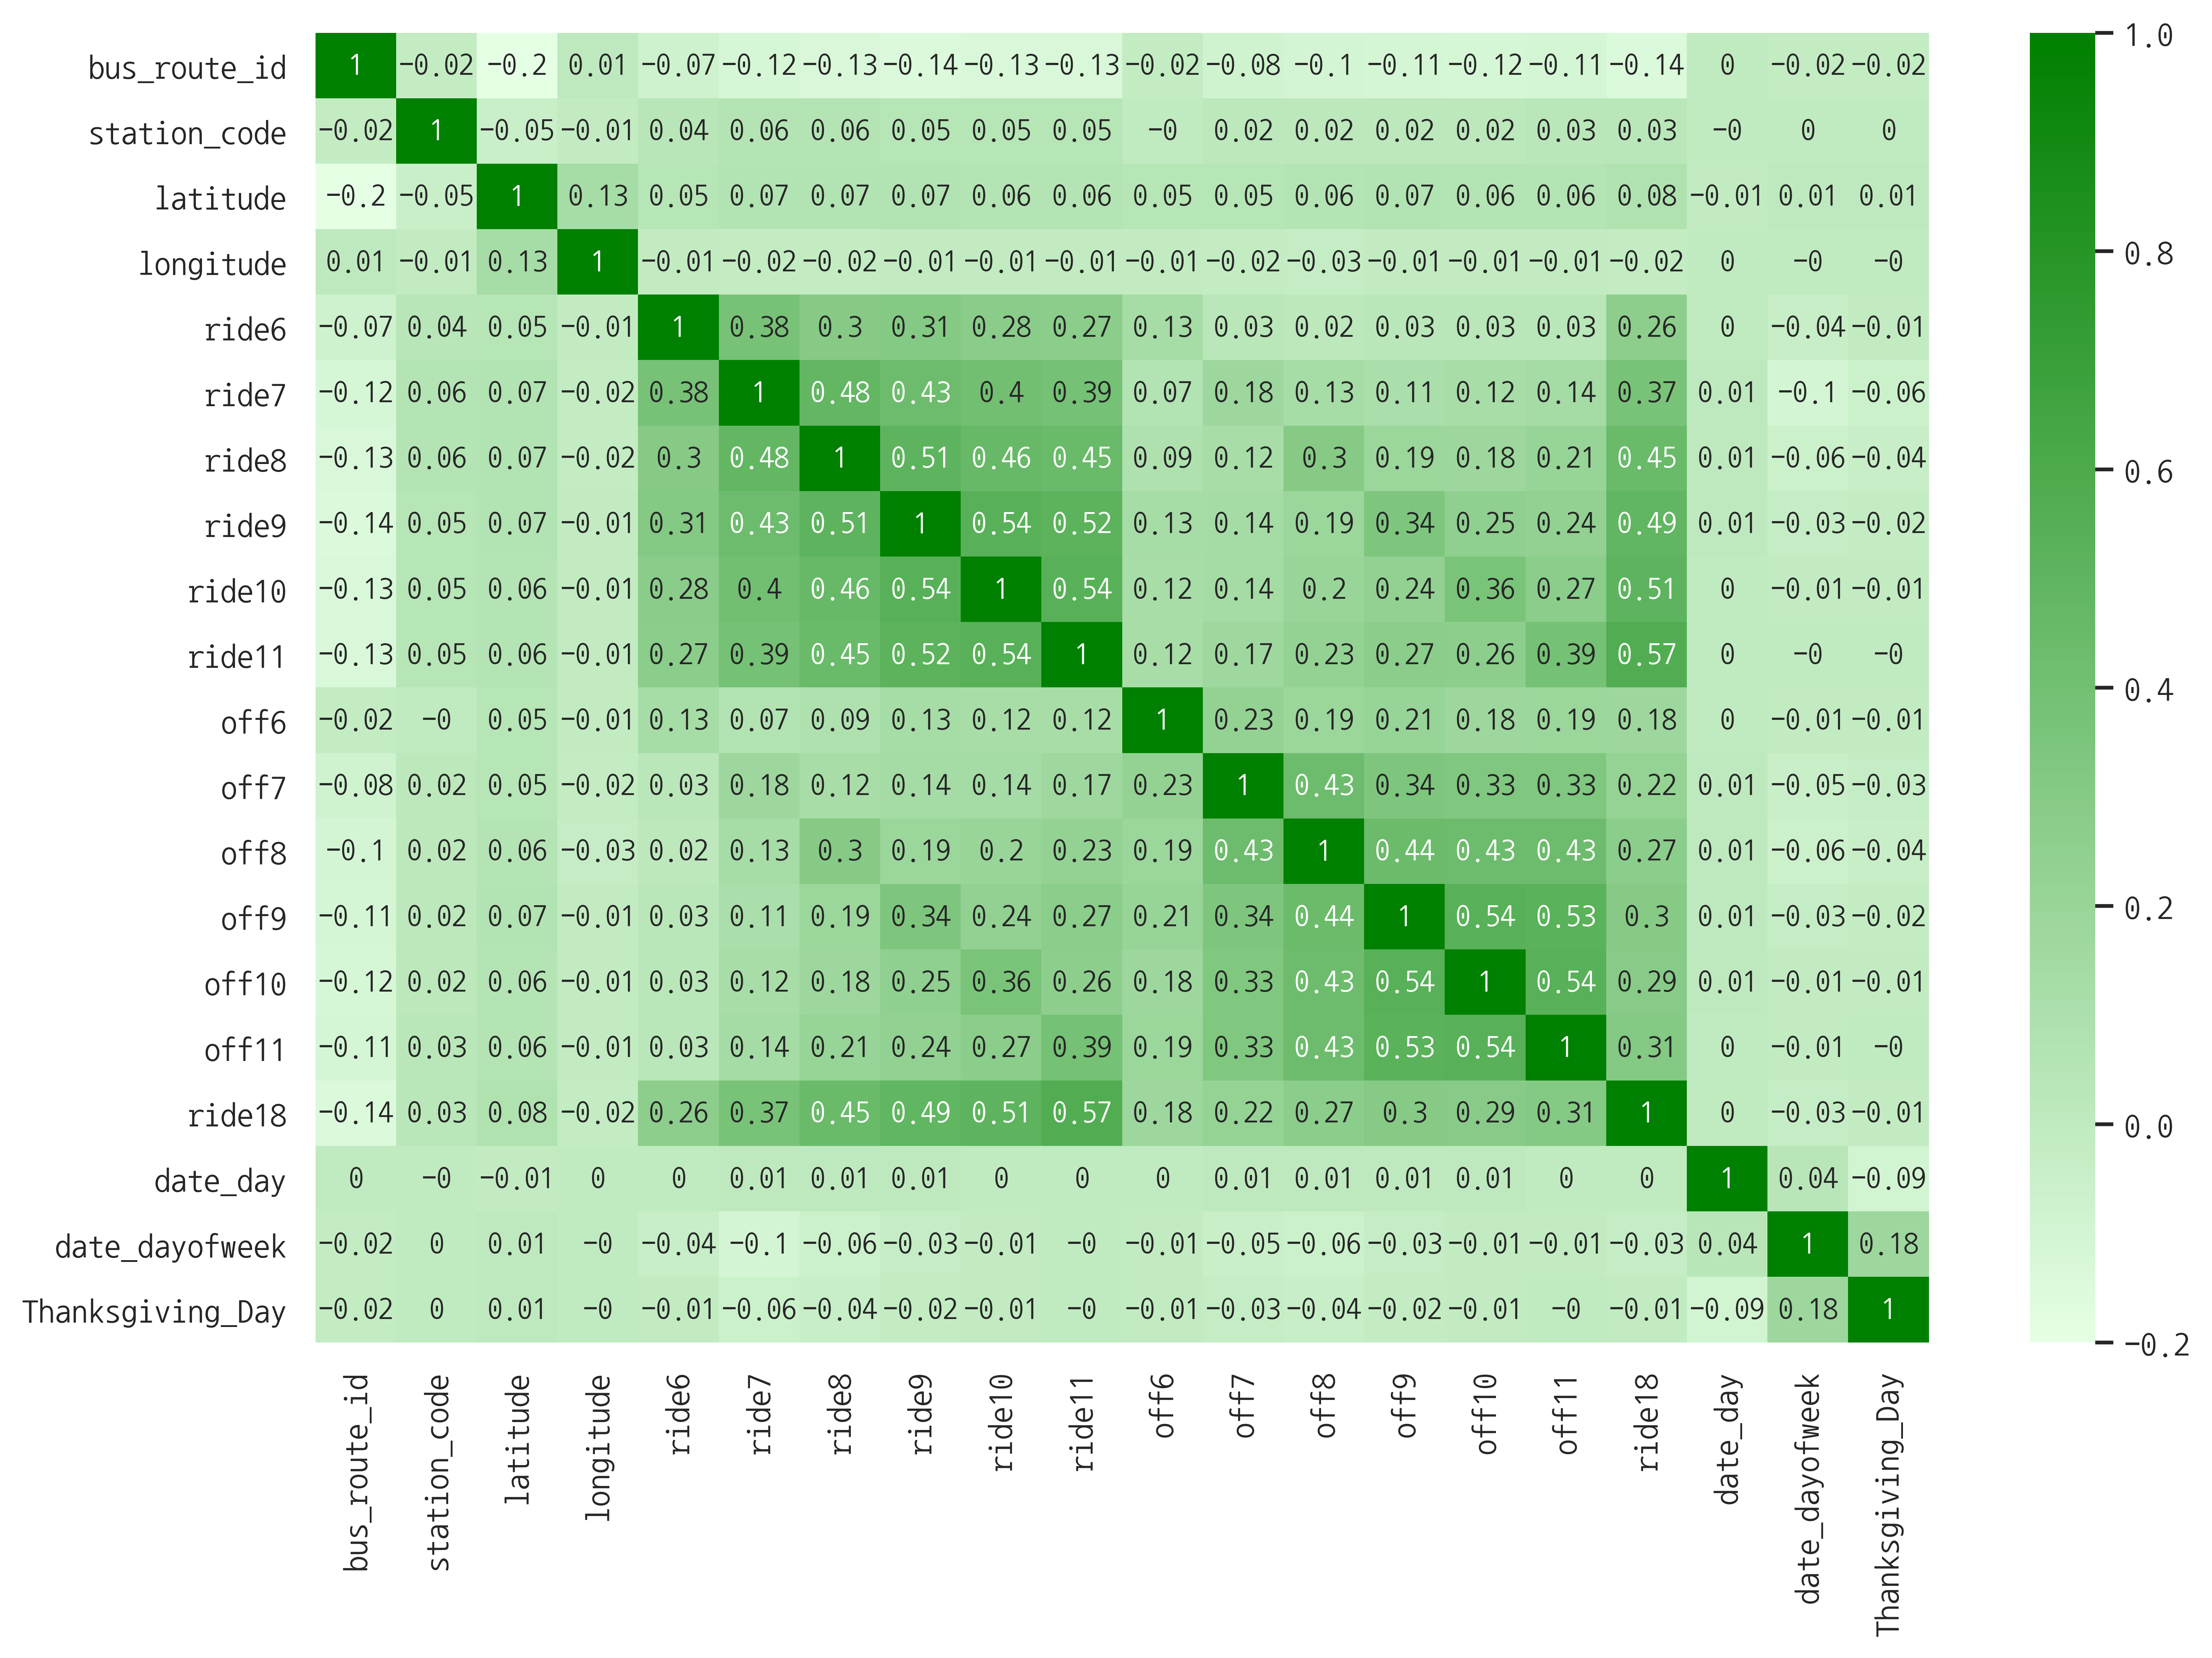

In [358]:
# 상관계수의 heatmap 화
plt.figure(figsize=(12, 8))
sns.heatmap(train_corr, annot=True, cmap=sns.light_palette("green", as_cmap=True))
plt.show()

In [360]:
# 모델에 넣을 변수만 저장
var = ['latitude', 'longitude', 'ride6', 'ride7', 'ride8',
       'ride9', 'ride10', 'ride11', 'off6', 'off7', 'off8', 'off9', 'off10',
       'off11', 'date_day', 'date_dayofweek']
cate = ['in_out','Thanksgiving_Day']

In [361]:
# scale변수로 변경
var_scale = [f"scale({name})" for name in var]
var_scale

['scale(latitude)',
 'scale(longitude)',
 'scale(ride6)',
 'scale(ride7)',
 'scale(ride8)',
 'scale(ride9)',
 'scale(ride10)',
 'scale(ride11)',
 'scale(off6)',
 'scale(off7)',
 'scale(off8)',
 'scale(off9)',
 'scale(off10)',
 'scale(off11)',
 'scale(date_day)',
 'scale(date_dayofweek)']

In [362]:
# 기본적인 내용만 OLS에 넣어봄
# 추석을 넣어도 0.444 이네요.
model = sm.OLS.from_formula(
    'ride18 ~ C(in_out) + C(Thanksgiving_Day) + '+'+'.join(var_scale), data=train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                 1.837e+04
Date:                Thu, 12 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:16:35   Log-Likelihood:            -1.1127e+06
No. Observations:              415423   AIC:                         2.225e+06
Df Residuals:                  415404   BIC:                         2.226e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

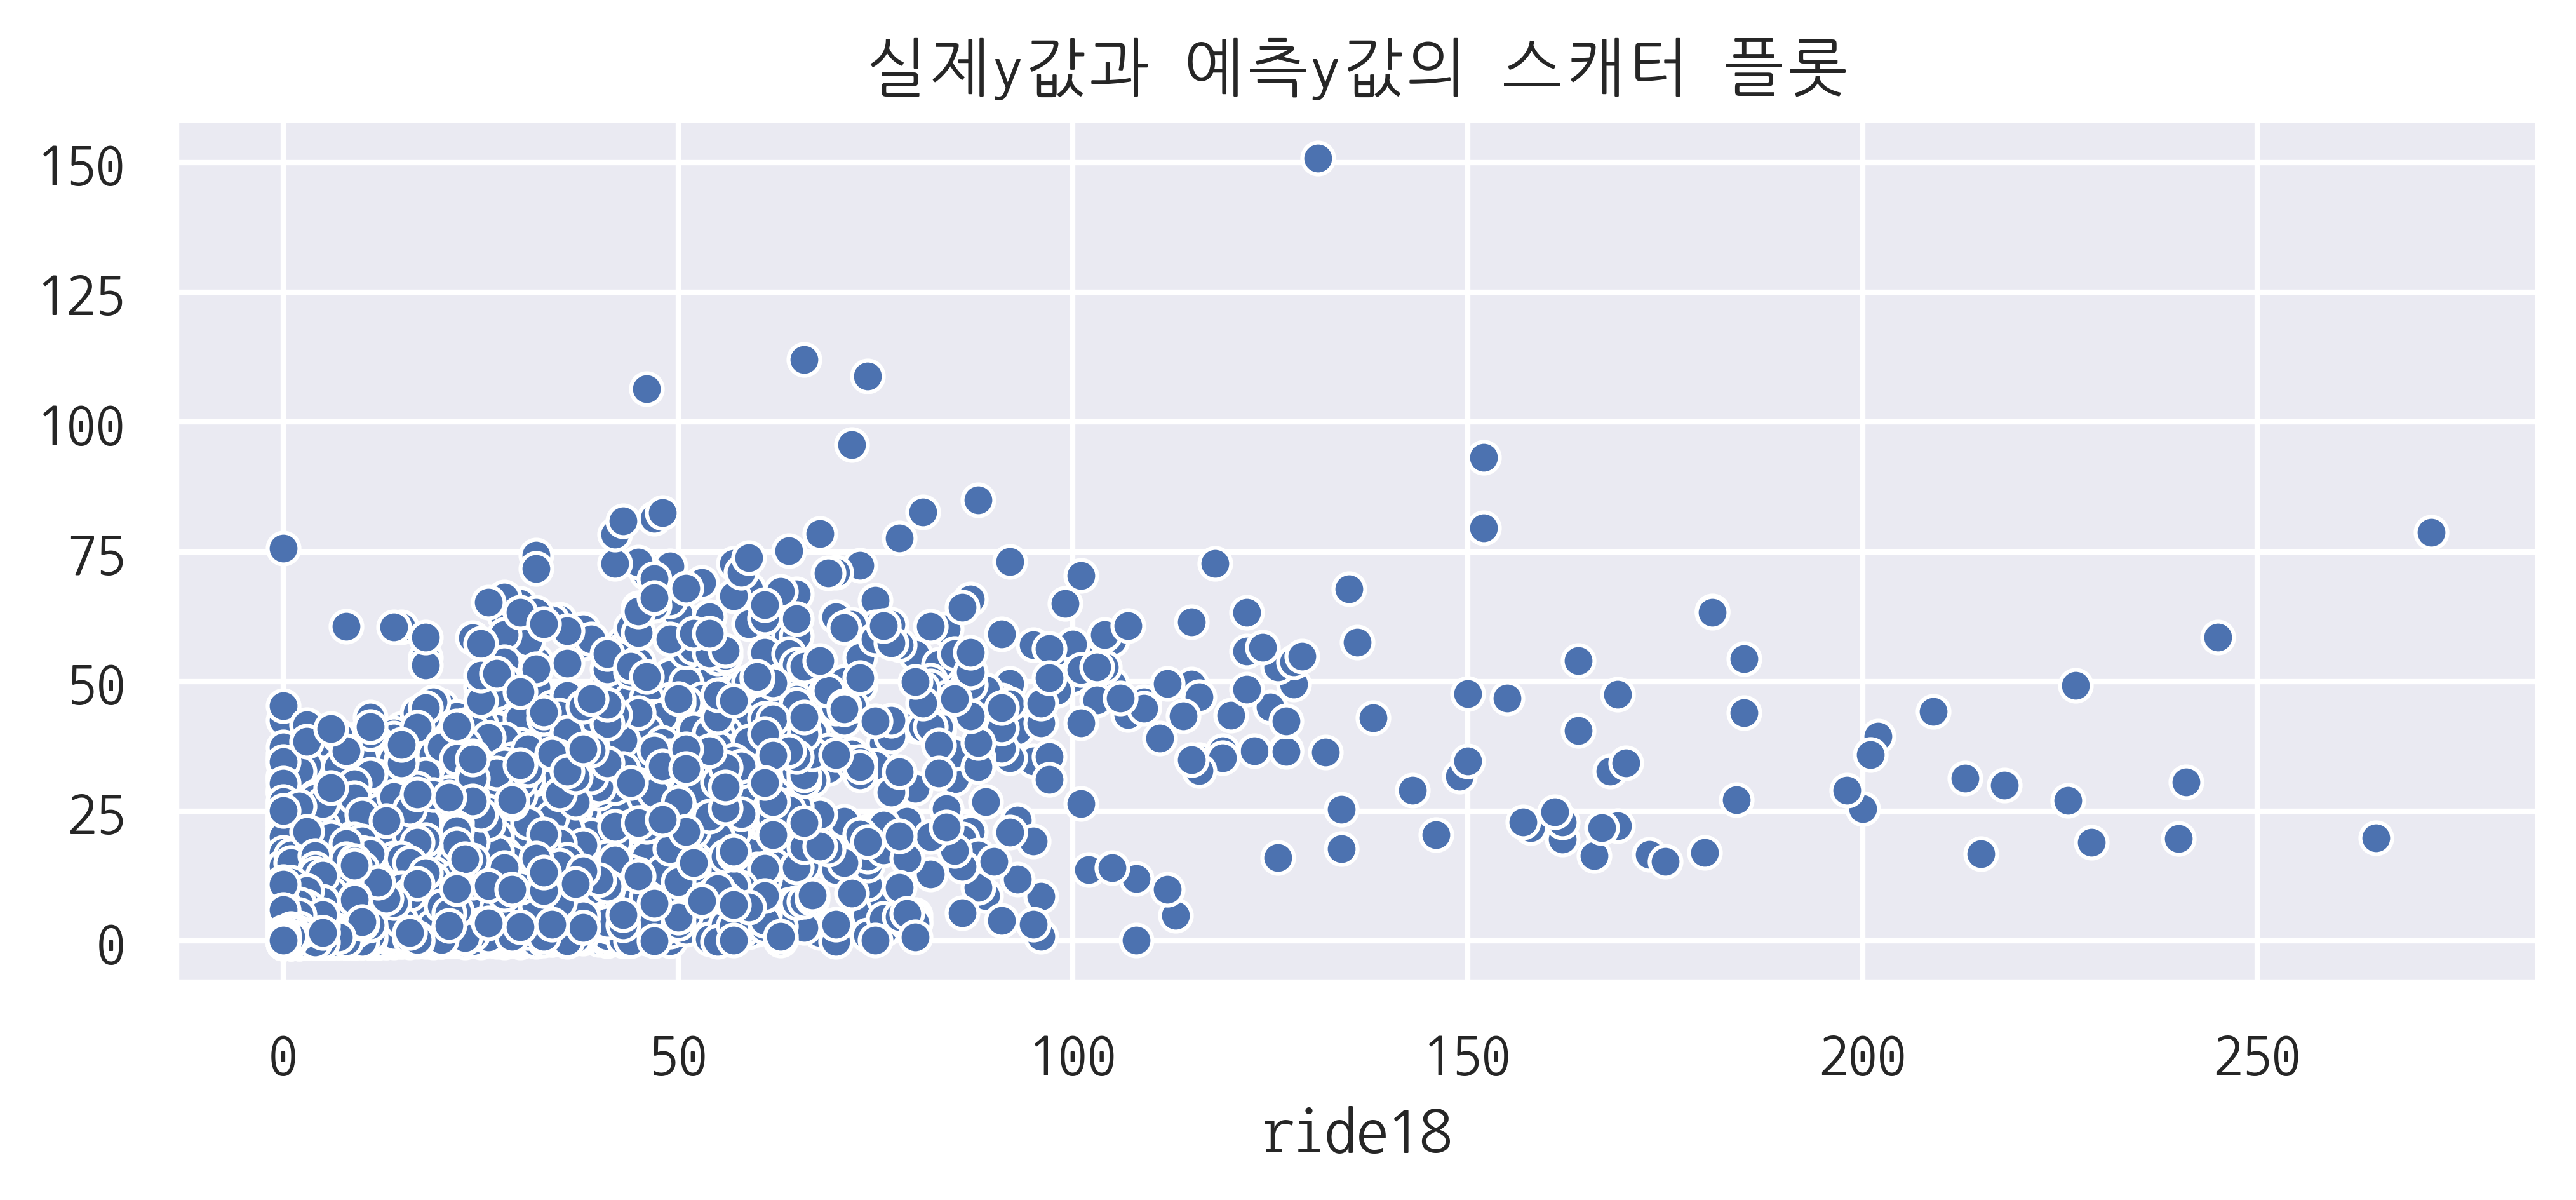

In [363]:
# R-squared : 0.443의 y값의 스캐터 플롯
# x를 scale 값으로 넣어야 하는건가?
y = result.predict()
x = train['ride18']
sns.scatterplot(x, y)
plt.title('실제y값과 예측y값의 스캐터 플롯')
plt.show()

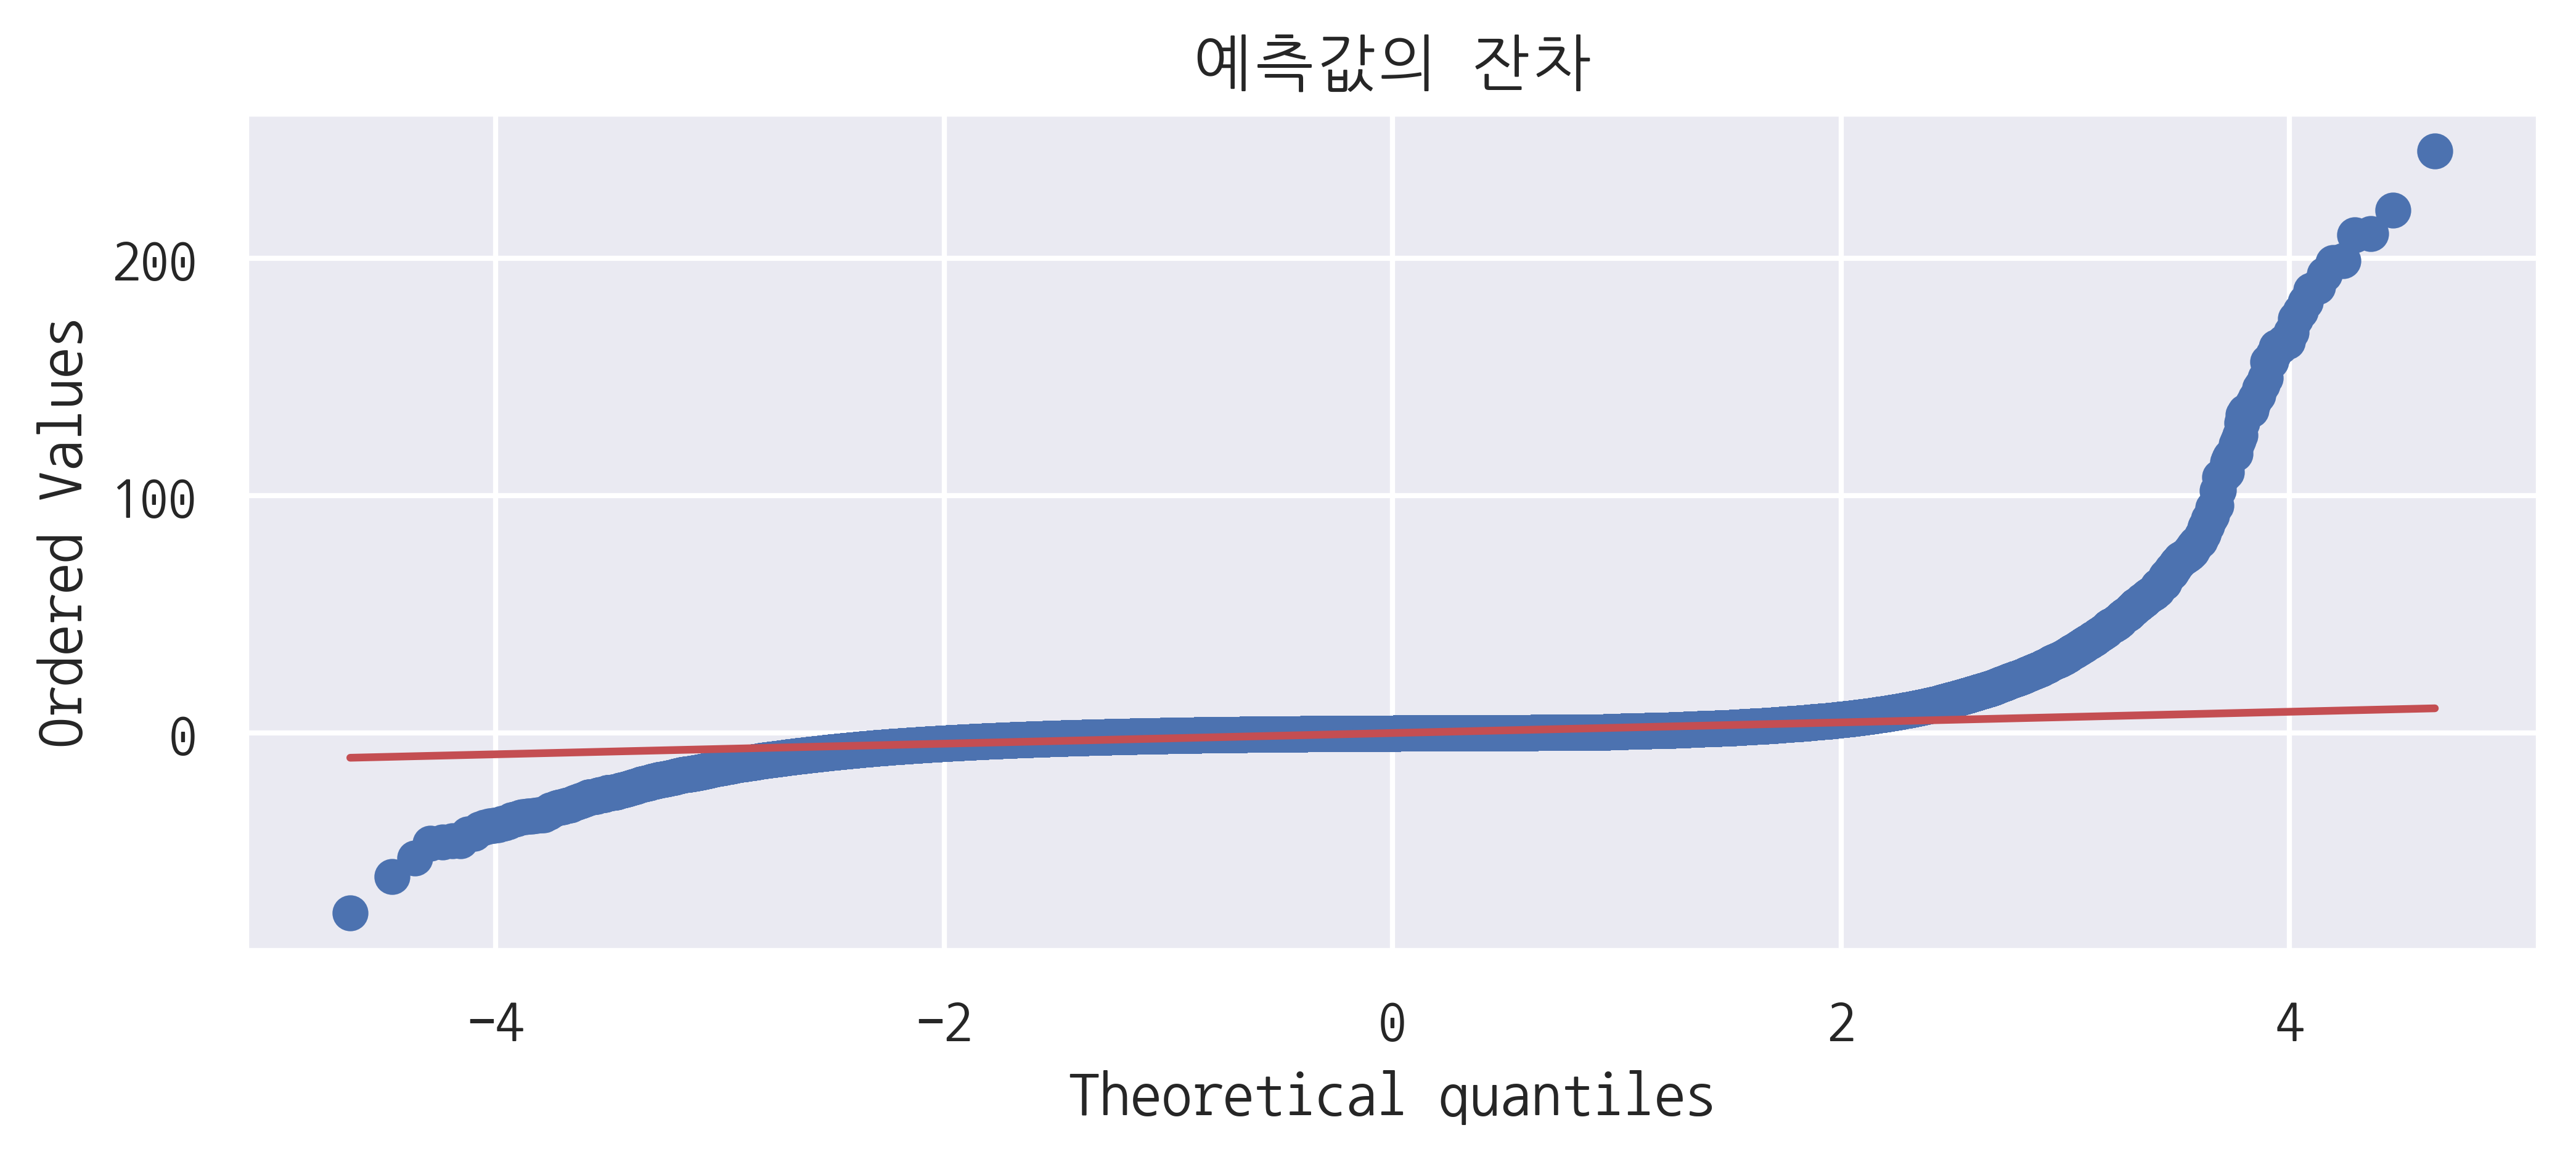

In [364]:
# 예측값의 잔차
# 데이터가 모형 가정을 따르지 않지만 잔차는 정규 분포를 따르는 것을 알 수 있다
sp.stats.probplot(result.resid, plot=plt)
plt.title('예측값의 잔차')
plt.show()

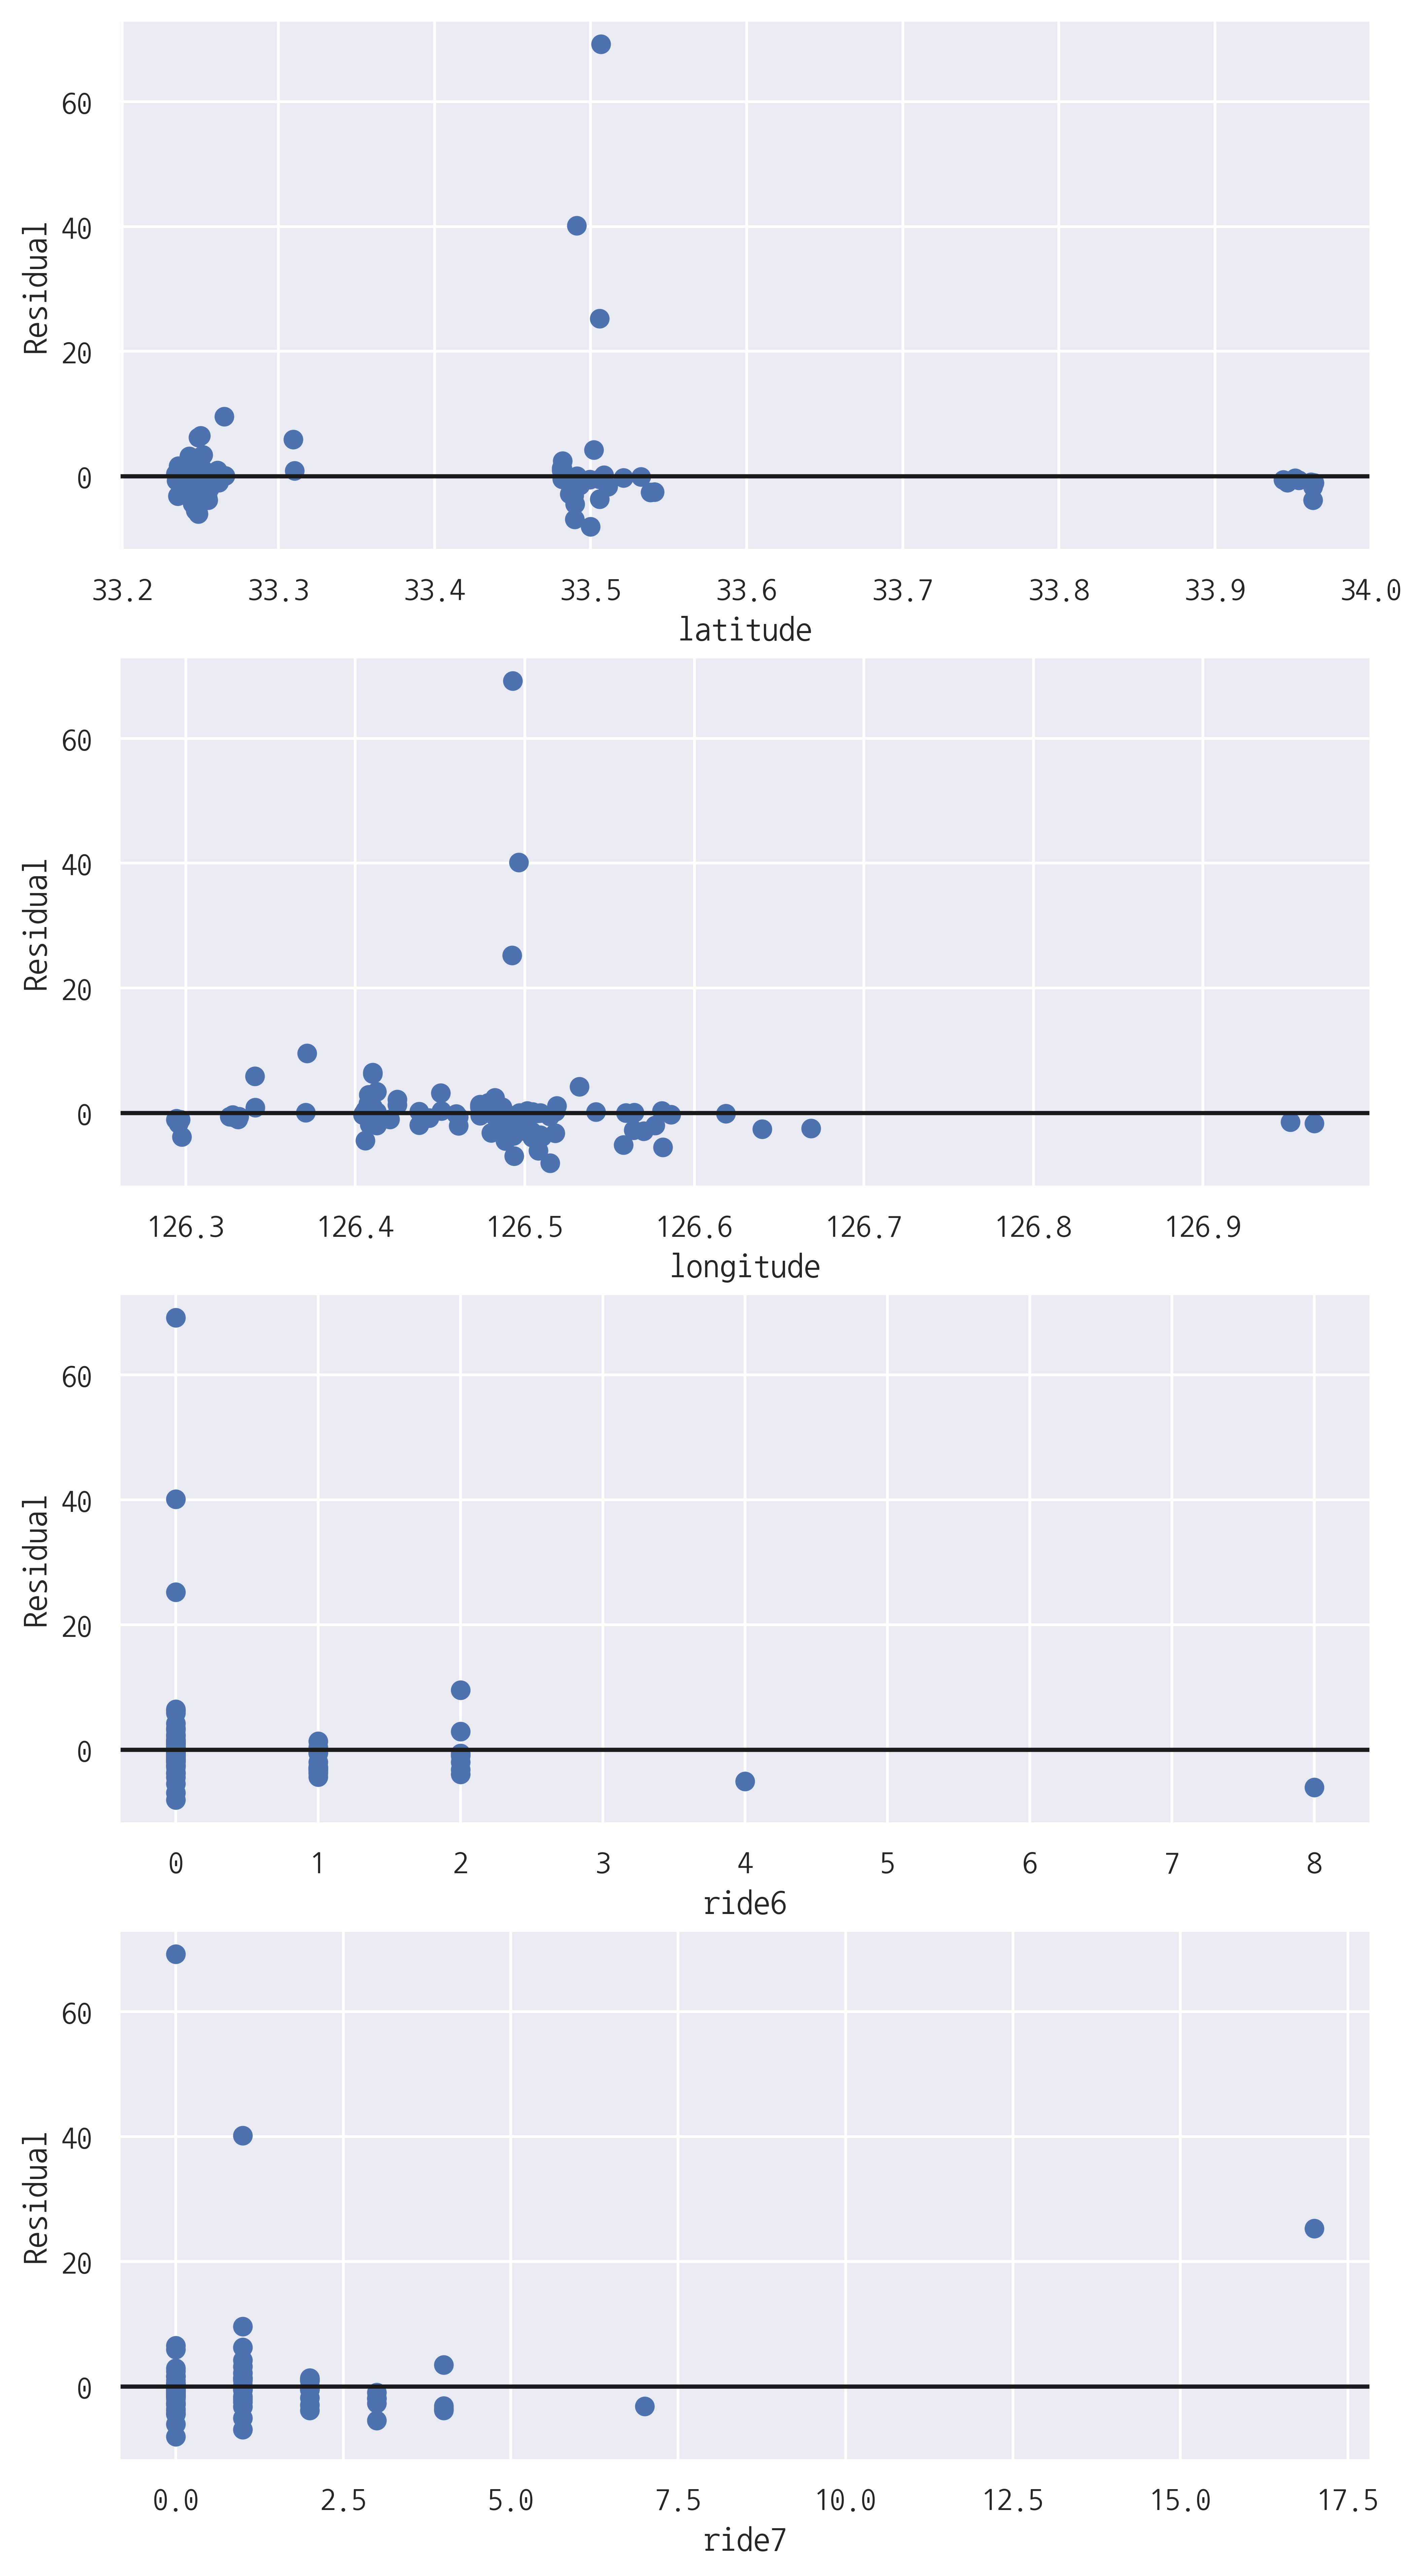

In [115]:
# 아래는 잔차와 독립변수간의 상관관계를 확인하는 그래프를 그리는중이였습니다.
# 나중에 OLS 하시고 변형하셔도 쓰셔도 될듯 합니다.
# 잔차와 독립변수간의 상관관계 확인
# 독립변수x를 스케일한 값으로 보아야하지않는가?

# plt.figure(figsize=(8,16))
# plt.subplot(411)
# plt.plot(train['latitude'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("latitude")
# plt.ylabel("Residual")

# plt.subplot(412)
# plt.plot(train['longitude'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("longitude")
# plt.ylabel("Residual")

# plt.subplot(413)
# plt.plot(train['ride6'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("ride6")
# plt.ylabel("Residual")

# plt.subplot(414)
# plt.plot(train['ride7'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("ride7")
# plt.ylabel("Residual")

# plt.tight_layout
# plt.show()

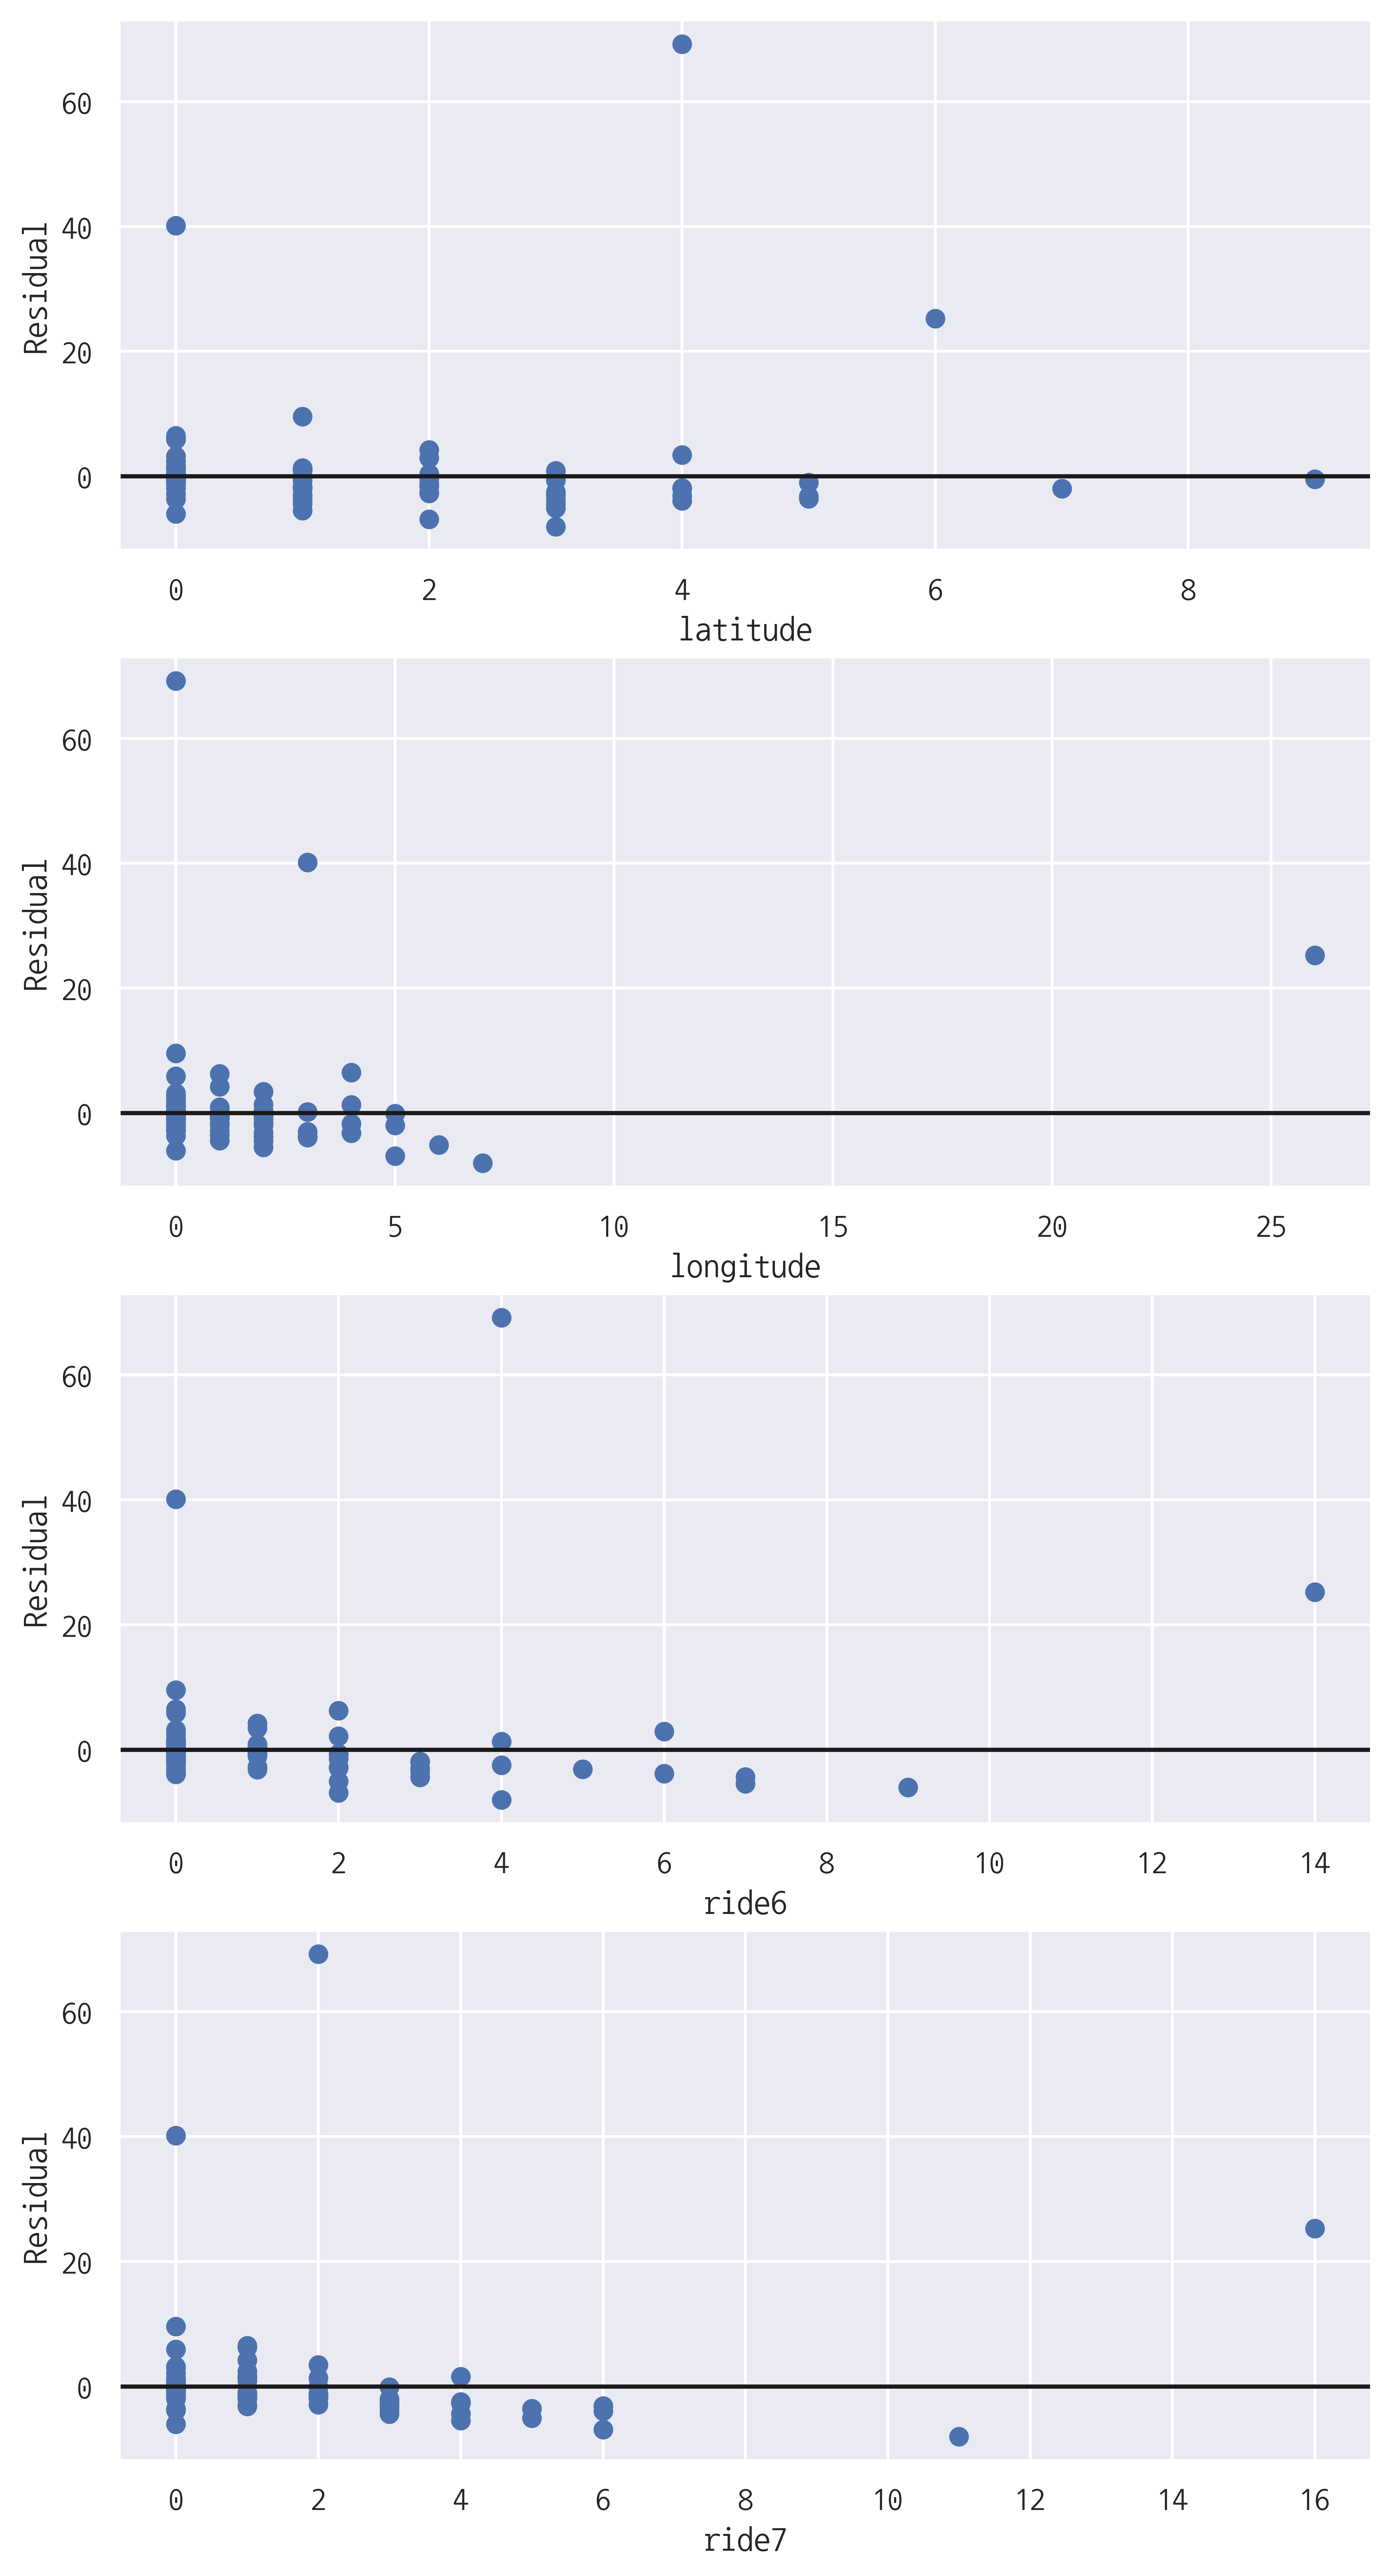

In [116]:
# plt.figure(figsize=(8,16))
# plt.subplot(411)
# plt.plot(train['ride8'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("latitude")
# plt.ylabel("Residual")

# plt.subplot(412)
# plt.plot(train['ride9'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("longitude")
# plt.ylabel("Residual")

# plt.subplot(413)
# plt.plot(train['ride10'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("ride6")
# plt.ylabel("Residual")

# plt.subplot(414)
# plt.plot(train['ride11'][:100], result.resid[:100], 'o')
# plt.axhline(y=0, c='k')
# plt.xlabel("ride7")
# plt.ylabel("Residual")

# plt.tight_layout
# plt.show()

In [365]:
# 여기아래부터 코드 작성해주세요.
# 중간에 적으면 알아보기 힘듬..